## Ingredient Recognition with PaliGemma

In this notebook, the vision-language model PaliGemma is used to recognize ingredients in pictures of meals. For this purpose, fine-tuning was performed on the Food-101 dataset in combination with the Ingredients-101 dataset. The implementation was based on the notebook from [Google](https://ai.google.dev/gemma/docs/paligemma/fine-tuning-paligemma), which shows how to perform fine-tuning with PaliGemma.

## Set up the Environment

### Install the required dependencies


1. In this notebook, `Python==3.11` is used. 

2. The following packages are required to run the notebook:
```bash
pip install python-dotenv kagglehub transformers gdown jax[cuda12] pillow ipykernel ipywidgets tensorflow ml-dtypes flax tqdm orbax-checkpoint matplotlib scikit-learn nltk rouge-score -U
```
3. The dataset 

Also, move `data/food-ingredients-101`, `data/food-101` & `data/ingredients-101` to root dir.

If `data/food-ingredients-101` is not present, create it using `merging_food101_ingredients101.ipynb`

3. Install gsutil https://cloud.google.com/storage/docs/gsutil_install?hl=de#linux

### Import the required libraries

In [ ]:
import os
import warnings
warnings.filterwarnings('ignore')
from dotenv import load_dotenv
import sys

import gdown

import base64
import functools
import html
import io
import warnings
import random
import kagglehub
import jax
import jax.numpy as jnp
import numpy as np
import ml_collections
import json


from PIL import Image
import tensorflow as tf
import sentencepiece

from IPython.core.display import display, HTML
from PIL import Image

# === Additional imports ===
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from sklearn.metrics import accuracy_score, precision_score, recall_score
from rouge_score import rouge_scorer
from tqdm import tqdm

# Don't let TF use the GPU or TPUs
tf.config.set_visible_devices([], "GPU")
tf.config.set_visible_devices([], "TPU")

backend = jax.lib.xla_bridge.get_backend()
print(f"JAX version:  {jax.__version__}")
print(f"JAX platform: {backend.platform}")
print(f"JAX devices:  {jax.device_count()}")

from flax.training import orbax_utils
import orbax.checkpoint

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MultiLabelBinarizer

### Set environment variables

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
load_dotenv()
os.environ["KAGGLE_USERNAME"] = os.getenv('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = os.getenv('KAGGLE_KEY')

In [4]:
!export KAGGLE_USERNAME
!export KAGGLE_KEY

### Prepare the `big_vision` repository

In [5]:
if not os.path.exists("big_vision_repo"):
  !git clone --quiet --branch=main --depth=1 \
     https://github.com/google-research/big_vision big_vision_repo

if "big_vision_repo" not in sys.path:
  sys.path.append("big_vision_repo")

!pip3 install -q "overrides" "ml_collections" "einops~=0.7" "sentencepiece"

In [ ]:
# import big vision modules
from big_vision.models.proj.paligemma import paligemma
from big_vision.trainers.proj.paligemma import predict_fns

import big_vision.datasets.jsonl
import big_vision.utils
import big_vision.sharding

## Prepare the model

### Download the model

The model is downloaded from Kaggle using the Kaggle API. The used model version is `google/paligemma/jax/paligemma-3b-pt-224`.

In [8]:
MODEL_PATH = "./pt_224_128.params.f16.npz"
if not os.path.exists(MODEL_PATH):
  print("Downloading the checkpoint from Kaggle, this could take a few minutes....")
  MODEL_PATH = kagglehub.model_download('google/paligemma/jax/paligemma-3b-pt-224', 'paligemma-3b-pt-224.f16.npz')

TOKENIZER_PATH = "./paligemma_tokenizer.model"
if not os.path.exists(TOKENIZER_PATH):
  print("Downloading the model tokenizer...")
  !gsutil cp gs://big_vision/paligemma_tokenizer.model {TOKENIZER_PATH}
  print(f"Tokenizer path: {TOKENIZER_PATH}")

In [9]:
FOOD_DATA_DIR="./food-101"
if not os.path.exists(FOOD_DATA_DIR):
  print("Downloading the dataset...")
  !kaggle datasets download -d kmader/food41
  !unzip -q food41.zip -d ./food-101
  print(f"Data path: {FOOD_DATA_DIR}")

INGREDIENTS_DATA_DIR = "./ingredients-101"
if not os.path.exists(INGREDIENTS_DATA_DIR):
    os.makedirs(INGREDIENTS_DATA_DIR)  # Ensure the target directory exists
    print("Downloading the dataset...")
    # Define the URL of the Google Drive file
    url = 'https://drive.google.com/uc?id=14ztu2gjdowZdMdCvo1tAZJ0aK5rMs4kb'
    # Define the output file path
    output = 'Ingredients101.zip'
    # Download the file
    gdown.download(url, output, quiet=False)
    # Unzip only the contents of the "Ingredients101" directory directly into the target directory
    os.system(f'unzip -q {output} "Ingredients101/*" -d {INGREDIENTS_DATA_DIR}')
    # Move contents up from the nested "Ingredients101" directory and remove it
    nested_dir = os.path.join(INGREDIENTS_DATA_DIR, 'Ingredients101')
    for filename in os.listdir(nested_dir):
        os.rename(os.path.join(nested_dir, filename), os.path.join(INGREDIENTS_DATA_DIR, filename))
    os.rmdir(nested_dir)
    # Clean up the zip file after extraction
    os.remove(output)
    print(f"Data path: {INGREDIENTS_DATA_DIR}")

### Configure the model

Due to the model's considerable size, certain parameters are frozen to reduce memory requirements and focus training on only the most relevant ones. Following this, the model parameters are loaded and a decoding function is defined, allowing outputs to be generated from the model efficiently within the given resource constraints.

In [10]:
# Define model for frozen config
model_config = ml_collections.FrozenConfigDict({
    "llm": {"vocab_size": 257_152},
    "img": {"variant": "So400m/14", "pool_type": "none", "scan": True, "dtype_mm": "float16"}
})
model = paligemma.Model(**model_config)
tokenizer = sentencepiece.SentencePieceProcessor(TOKENIZER_PATH)

# Load params
params = paligemma.load(None, MODEL_PATH, model_config)

# Define decode function
decode_fn = predict_fns.get_all(model)['decode']
decode = functools.partial(decode_fn, devices=jax.devices(), eos_token=tokenizer.eos_id())

### Move model parameters into GPU memory

This section implements parameter management across available GPUs, sharding and loading them sequentially to address memory limitations. Then it differentiates between trainable and frozen parameters, converting them to appropriate data types to optimize training efficiency and memory usage.

In [11]:
# Define what params should be trained
def is_trainable_param(name, param):
  if name.startswith("llm/layers/attn/"):  return True
  if name.startswith("llm/"):              return False
  if name.startswith("img/"):              return False
  raise ValueError(f"Unexpected param name {name}")
trainable_mask = big_vision.utils.tree_map_with_names(is_trainable_param, params)

mesh = jax.sharding.Mesh(jax.devices(), ("data"))

data_sharding = jax.sharding.NamedSharding(
    mesh, jax.sharding.PartitionSpec("data"))

params_sharding = big_vision.sharding.infer_sharding(
    params, strategy=[('.*', 'fsdp(axis="data")')], mesh=mesh)

warnings.filterwarnings(
    "ignore", message="Some donated buffers were not usable")

@functools.partial(jax.jit, donate_argnums=(0,), static_argnums=(1,))
def maybe_cast_to_f32(params, trainable):
  return jax.tree.map(lambda p, m: p.astype(jnp.float32) if m else p,
                      params, trainable)

params, treedef = jax.tree.flatten(params)
sharding_leaves = jax.tree.leaves(params_sharding)
trainable_leaves = jax.tree.leaves(trainable_mask)
for idx, (sharding, trainable) in enumerate(zip(sharding_leaves, trainable_leaves)):
  params[idx] = big_vision.utils.reshard(params[idx], sharding)
  params[idx] = maybe_cast_to_f32(params[idx], trainable)
  params[idx].block_until_ready()
params = jax.tree.unflatten(treedef, params)

def parameter_overview(params):
  for path, arr in big_vision.utils.tree_flatten_with_names(params)[0]:
    print(f"{path:80s} {str(arr.shape):22s} {arr.dtype}")

# print(" == Model params == ")
# parameter_overview(params)

2024-08-05 15:12:59.456147: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.82). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## Prepare to tune the model

Now that your model is configured, you can tune it. In this step, you'll create your model's inputs as well as the training and validation iterators, view the training examples, and define the training and validation loops.

### Create model inputs

Three essential functions are defined for preprocessing and postprocessing model inputs. These functions handle the normalization of image data, processing of token sequences with specific flags for prefix and suffix tokens, and cleaning of output tokens. 

In [12]:
def preprocess_image(image, size=224):
  image = np.asarray(image)
  if image.ndim == 2: 
    image = np.stack((image,)*3, axis=-1)
  image = image[..., :3]
  assert image.shape[-1] == 3

  image = tf.constant(image)
  image = tf.image.resize(image, (size, size), method='bilinear', antialias=True)
  return image.numpy() / 127.5 - 1.0 

def preprocess_tokens(prefix, suffix=None, seqlen=None):
    separator = "\n"
    tokens = tokenizer.encode(prefix, add_bos=True) + tokenizer.encode(separator)
    mask_ar = [0] * len(tokens)
    mask_loss = [0] * len(tokens)

    if suffix:
        suffix_tokens = tokenizer.encode(suffix, add_eos=True)
        tokens += suffix_tokens
        mask_ar += [1] * len(suffix_tokens)
        mask_loss += [1] * len(suffix_tokens)

    mask_input = [1] * len(tokens)
    if seqlen:
        padding = [0] * max(0, seqlen - len(tokens))
        tokens = tokens[:seqlen] + padding
        mask_ar = mask_ar[:seqlen] + padding
        mask_loss = mask_loss[:seqlen] + padding
        mask_input = mask_input[:seqlen] + padding

    return jax.tree.map(np.array, (tokens, mask_ar, mask_loss, mask_input))

def postprocess_tokens(tokens):
  tokens = tokens.tolist()
  try:
    eos_pos = tokens.index(tokenizer.eos_id())
    tokens = tokens[:eos_pos]
  except ValueError:
    pass
  return tokenizer.decode(tokens)

### Create the training and validation iterators

Next, the training, validation, and testing datasets are prepared. Two iterators are created to manage data flow during model training and evaluation. The training iterator processes data in chunks with pre-processing capabilities, while the validation iterator allows for periodic assessment of the tuned model's performance against provided results.

In [14]:
DATA_DIR = './food-ingredients-101'

In [15]:
def merge_data(food_data_dir, ingredients_data_dir, data_dir):
    os.makedirs(data_dir, exist_ok=True)

    # Define the paths to the required files
    food_train_file = os.path.join(food_data_dir, 'meta', 'train.json')
    food_test_file = os.path.join(food_data_dir, 'meta', 'test.json')
    food_val_file = os.path.join(food_data_dir, 'meta', 'valid.json')
    ingredients_train_images = os.path.join(ingredients_data_dir, 'Annotations', 'train_images.txt')
    ingredients_train_labels = os.path.join(ingredients_data_dir, 'Annotations', 'train_labels.txt')
    ingredients_test_images = os.path.join(ingredients_data_dir, 'Annotations', 'test_images.txt')
    ingredients_test_labels = os.path.join(ingredients_data_dir, 'Annotations', 'test_labels.txt')
    ingredients_val_images = os.path.join(ingredients_data_dir, 'Annotations', 'val_images.txt')
    ingredients_val_labels = os.path.join(ingredients_data_dir, 'Annotations', 'val_labels.txt')
    ingredients_file = os.path.join(ingredients_data_dir, 'Annotations', 'ingredients.txt')

    # Load the ingredients data
    with open(ingredients_file, 'r') as f:
        ingredients_list = [line.strip() for line in f.readlines()]

    # Create a dictionary to map each class to its ingredients
    class_to_ingredients = {i: ingredients for i, ingredients in enumerate(ingredients_list)}

    def create_jsonl(image_file, label_file, split):
        with open(image_file, 'r') as f:
            image_paths = [line.strip() for line in f.readlines()]

        with open(label_file, 'r') as f:
            labels = [int(line.strip()) for line in f.readlines()]

        if len(image_paths) != len(labels):
            raise ValueError("The number of images and labels do not match.")

        output_file = os.path.join(data_dir, f'{split}.jsonl')
        with open(output_file, 'w') as f_out:
            for image_path, label in zip(image_paths, labels):
                ingredients = class_to_ingredients[label]
                suffix = ', '.join(ingredients.split(','))
                record = {
                    "prefix": "",
                    "suffix": suffix,
                    "image": food_data_dir + '/images/' + image_path + '.jpg',
                }
                f_out.write(json.dumps(record) + '\n')

    create_jsonl(ingredients_train_images, ingredients_train_labels, 'train')
    create_jsonl(ingredients_test_images, ingredients_test_labels, 'test')
    create_jsonl(ingredients_val_images, ingredients_val_labels, 'val')

if not os.path.exists(DATA_DIR) or len(os.listdir(DATA_DIR)) == 0:  
    merge_data('food-101', 'ingredients-101', 'food-ingredients-101')

In [16]:
SEQLEN = 128

train_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "train.jsonl"),
    # fopen_keys={"image": FOOD_DATA_DIR}
    )

val_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "val.jsonl"),
    # fopen_keys={"image": FOOD_DATA_DIR}
    )

test_dataset = big_vision.datasets.jsonl.DataSource(
    os.path.join(DATA_DIR, "test.jsonl"),
    # fopen_keys={"image": FOOD_DATA_DIR}
    )

In [ ]:
def train_data_iterator():
    dataset = train_dataset.get_tfdata().shuffle(1_000).repeat()
    for example in dataset.as_numpy_iterator():
        try:
            image_path = example["image"].decode()
            image = Image.open(image_path)
            image = preprocess_image(image)
        except Exception as e:
            print(f"Error opening image at {image_path}: {e}")
            continue

        prefix = "caption en"
        suffix = example["suffix"].decode().lower()
        tokens, mask_ar, mask_loss, _ = preprocess_tokens(prefix, suffix, SEQLEN)

        yield {
            "image": np.asarray(image),
            "text": np.asarray(tokens),
            "mask_ar": np.asarray(mask_ar),
            "mask_loss": np.asarray(mask_loss),
        }


def validation_data_iterator():
  """Single iterator over validation examples."""
  for example in val_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    try:
        image_path = example["image"].decode()
        image = Image.open(image_path)
        image = preprocess_image(image)
    except Exception as e:
        continue

    prefix = "caption en"
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }


def test_data_iterator():
  """Single iterator over test examples."""
  for example in test_dataset.get_tfdata(ordered=True).as_numpy_iterator():
    try:
        image_path = example["image"].decode()
        image = Image.open(image_path)
        image = preprocess_image(image)
    except Exception as e:
        continue

    prefix = "caption en"
    tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)

    yield {
        "image": np.asarray(image),
        "text": np.asarray(tokens),
        "mask_ar": np.asarray(mask_ar),
        "mask_input": np.asarray(mask_input),
    }

### View training examples

Training examples



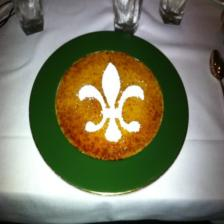
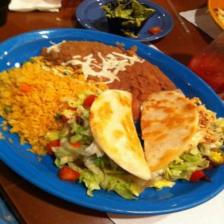
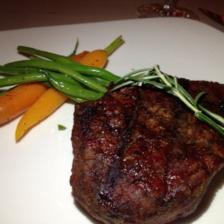
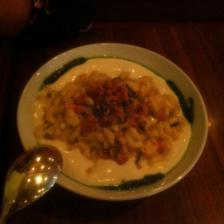
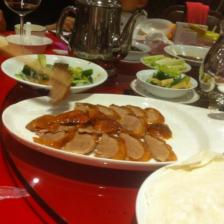
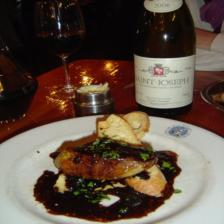
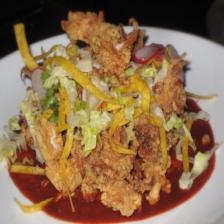
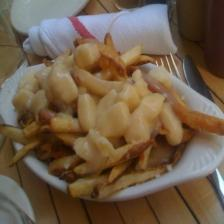

In [17]:
def render_inline(image, resize=(128, 128)):
  image = Image.fromarray(image)
  image.resize(resize)
  with io.BytesIO() as buffer:
    image.save(buffer, format='jpeg')
    image_b64 = str(base64.b64encode(buffer.getvalue()), "utf-8")
    return f"data:image/jpeg;base64,{image_b64}"

def render_example(image, caption):
  image = ((image + 1)/2 * 255).astype(np.uint8)
  return f"""
    <div style="display: inline-flex; align-items: center; justify-content: center;">
        <img style="width:128px; height:128px;" src="{render_inline(image, resize=(64,64))}" />
        <p style="width:256px; margin:10px; font-size:small;">{html.escape(caption)}</p>
    </div>
    """

html_out = ""
for idx, example in zip(range(8), train_data_iterator()):
  caption = postprocess_tokens(example["text"]) 
  caption = caption[len("caption en\n"):]        
  html_out += render_example(example["image"], caption)

print("Training examples")
display(HTML(html_out))

### Define the training and evaluation loops

To train the model, the training and evaluation loops need to be defined. The update_fn function implements the training loop, calculating loss per example while accounting for masked tokens and applying stochastic gradient descent to optimize trainable parameters. The make_predictions function sets up the evaluation loop, handling batched predictions and accommodating the small dataset size by padding examples when necessary.

In [18]:
@functools.partial(jax.jit, donate_argnums=(0,))
def update_fn(params, batch, learning_rate):
  imgs, txts, mask_ar = batch["image"], batch["text"], batch["mask_ar"]

  def loss_fn(params):
    text_logits, _ = model.apply({"params": params}, imgs, txts[:, :-1], mask_ar[:, :-1], train=True)
    logp = jax.nn.log_softmax(text_logits, axis=-1)

    mask_loss = batch["mask_loss"][:, 1:]
    targets = jax.nn.one_hot(txts[:, 1:], text_logits.shape[-1])

    token_pplx = jnp.sum(logp * targets, axis=-1)
    example_loss = -jnp.sum(token_pplx * mask_loss, axis=-1) 
    example_loss /= jnp.clip(jnp.sum(mask_loss, -1), 1)

    return jnp.mean(example_loss)

  loss, grads = jax.value_and_grad(loss_fn)(params)

  def apply_grad(param, gradient, trainable):
    if not trainable: return param
    return param - learning_rate * gradient

  params = jax.tree_util.tree_map(apply_grad, params, grads, trainable_mask)

  return params, loss

def make_predictions(data_iterator, *, num_examples=None,
                     batch_size=4, seqlen=SEQLEN, sampler="greedy"):
  outputs = []
  while True:
    examples = []
    try:
      for _ in range(batch_size):
        examples.append(next(data_iterator))
        examples[-1]["_mask"] = np.array(True)
    except StopIteration:
      if len(examples) == 0:
        return outputs

    while len(examples) % batch_size:
      examples.append(dict(examples[-1]))
      examples[-1]["_mask"] = np.array(False)

    batch = jax.tree.map(lambda *x: np.stack(x), *examples)
    batch = big_vision.utils.reshard(batch, data_sharding)

    tokens = decode({"params": params}, batch=batch,
                    max_decode_len=seqlen, sampler=sampler)

    tokens, mask = jax.device_get((tokens, batch["_mask"]))
    tokens = tokens[mask] 
    responses = [postprocess_tokens(t) for t in tokens]

    for example, response in zip(examples, responses):
      outputs.append((example["image"], response))
      if num_examples and len(outputs) >= num_examples:
        return outputs

## Tune the model

Now the model is nearly ready to be tuned. In this step, a checkpoint manager is defined to save the model's parameters during training and a evaluation pipeline is implemented for the trained model. Functions for data preparation, metric calculation, and batch evaluation are also defined. The pipeline allows for a detailed evaluation of the model's performance by calculating various metrics such as BLEU, ROUGE, and several F1 score variants.

Then, a training loop is set up, including learning rate scheduling, progress tracking, and integration with Weights & Biases for experiment logging. The training process incorporates evaluation on a validation set every 200 steps, allowing for model checkpointing based on improvements in the F1 score.

In [20]:
# setup the checkpoint manager to save the model

ckpt_dir = os.path.join(os.getcwd(), 'checkpoints')

pytree_checkpointer = orbax.checkpoint.PyTreeCheckpointer()

options = orbax.checkpoint.CheckpointManagerOptions(
    max_to_keep=3,
    create=True
)

checkpoint_manager = orbax.checkpoint.CheckpointManager(
    ckpt_dir, pytree_checkpointer, options
)

In [21]:
# function to batchwise iterate over the validation data
def batch_val_score_iterator(batch_size=4, num_examples=None, seed=42):
    random.seed(seed)
    
    all_examples = []
    class_examples = {}
    
    for example in val_dataset.get_tfdata().as_numpy_iterator():
        try:
            image_path = example["image"].decode()
            image_class = image_path.split('/images/')[1].split('/')[0]
            
            image = Image.open(image_path)
            image = preprocess_image(image)
            
            prefix = "caption en"
            suffix = example["suffix"].decode().lower()
            tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
            
            processed_example = {
                "image": np.asarray(image),
                "text": np.asarray(tokens),
                "mask_ar": np.asarray(mask_ar),
                "mask_input": np.asarray(mask_input),
                "suffix": suffix,
                "class": image_class,
                "image_path": image_path
            }
            
            all_examples.append(processed_example)
            
            if image_class not in class_examples:
                class_examples[image_class] = []
            class_examples[image_class].append(processed_example)
            
        except Exception as e:
            print(f"Error processing image: {e}")
            continue
    
    if num_examples is None:
        num_examples = len(all_examples)
    
    # Ensure at least one example from each class
    selected_examples = []
    for examples in class_examples.values():
        if examples:
            selected_examples.append(random.choice(examples))
    
    # Distribute remaining examples while maintaining class balance
    remaining_slots = num_examples - len(selected_examples)
    selected_image_paths = set(ex['image_path'] for ex in selected_examples)
    
    while remaining_slots > 0:
        for class_name, examples in class_examples.items():
            if remaining_slots > 0:
                remaining_class_examples = [ex for ex in examples if ex['image_path'] not in selected_image_paths]
                if remaining_class_examples:
                    selected_example = random.choice(remaining_class_examples)
                    selected_examples.append(selected_example)
                    selected_image_paths.add(selected_example['image_path'])
                    remaining_slots -= 1
            if remaining_slots == 0:
                break
    
    random.shuffle(selected_examples)
    
    # Yield batches
    for i in range(0, len(selected_examples), batch_size):
        yield selected_examples[i:i+batch_size]

# function to batchwise iterate over the test data
def batch_test_score_iterator(batch_size=4, ordered=False):
    examples = []
    for example in test_dataset.get_tfdata(ordered=ordered).as_numpy_iterator():
        try:
            image_path = example["image"].decode()
            image = Image.open(image_path)
            image = preprocess_image(image)
            
            prefix = "caption en"
            suffix = example["suffix"].decode().lower()
            tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
            
            examples.append({
                "image": np.asarray(image),
                "text": np.asarray(tokens),
                "mask_ar": np.asarray(mask_ar),
                "mask_input": np.asarray(mask_input),
                "suffix": suffix,
            })
            
            if len(examples) == batch_size:
                yield examples
                examples = []
        except Exception as e:
            print(f"Error processing image: {e}")
            continue
    
    if examples:
        yield examples

# function for stratified batchwise iteration over the test data
def stratified_batch_test_score_iterator(batch_size=4, num_examples=None, ordered=False, seed=42):
    random.seed(seed)
    
    # Get all data
    all_data = list(test_dataset.get_tfdata(ordered=ordered).as_numpy_iterator())
    
    # Group the data by class
    classes = {}
    for item in all_data:
        class_name = item['image'].decode().split('/')[3]  # Adjust this index if necessary
        if class_name not in classes:
            classes[class_name] = []
        classes[class_name].append(item)

    # Calculate the number of samples per class
    num_classes = len(classes)
    samples_per_class = num_examples // num_classes if num_examples else len(all_data) // num_classes

    # Perform stratified sampling with validation
    stratified_sample = []
    class_counts = {}
    for class_name, items in classes.items():
        valid_items = [item for item in items if is_valid_image(item['image'].decode())]
        if len(valid_items) >= samples_per_class:
            selected = random.sample(valid_items, samples_per_class)
            stratified_sample.extend(selected)
            class_counts[class_name] = len(selected)
        else:
            stratified_sample.extend(valid_items)
            class_counts[class_name] = len(valid_items)
    
    # If there aren't enough samples, add more from classes with extra valid samples
    while len(stratified_sample) < (num_examples or len(all_data)):
        for class_name, items in classes.items():
            if len(stratified_sample) >= (num_examples or len(all_data)):
                break
            valid_items = [item for item in items if is_valid_image(item['image'].decode()) and item not in stratified_sample]
            if valid_items:
                stratified_sample.append(random.choice(valid_items))
                class_counts[class_name] += 1

    print("Classes and their sample counts:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count}")

    # Yield batches
    examples = []
    for item in stratified_sample:
        try:
            image_path = item["image"].decode()
            image = Image.open(image_path)
            image = preprocess_image(image)
            
            prefix = "caption en"
            suffix = item["suffix"].decode().lower()
            tokens, mask_ar, _, mask_input = preprocess_tokens(prefix, seqlen=SEQLEN)
            
            examples.append({
                "image": np.asarray(image),
                "text": np.asarray(tokens),
                "mask_ar": np.asarray(mask_ar),
                "mask_input": np.asarray(mask_input),
                "suffix": suffix,
            })
            
            if len(examples) == batch_size:
                yield examples
                examples = []
        except Exception as e:
            print(f"Error processing image: {e}")
            continue
    
    if examples:
        yield examples

In [ ]:
# function to calculate the ROUGE score
def compute_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return (scores['rouge1'].fmeasure + scores['rouge2'].fmeasure + scores['rougeL'].fmeasure) / 3

# function to calculate the F1-Score via ingredient overlap (old implementation)
def ingredient_overlap_f1_score(reference, candidate):
    ref_ingredients = set(reference.lower().split(', '))
    cand_ingredients = set(candidate.lower().split(', '))
    overlap = ref_ingredients.intersection(cand_ingredients)
    precision = len(overlap) / len(cand_ingredients) if cand_ingredients else 0
    recall = len(overlap) / len(ref_ingredients) if ref_ingredients else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

# function to calculate the F1-Score using sklearn
def ingredient_overlap_f1_sklearn(references, candidates, method):
    mlb = MultiLabelBinarizer()
    
    # Fit on both references and candidates to include all possible ingredients
    all_ingredients = set()
    for ref, cand in zip(references, candidates):
        all_ingredients.update(ref.lower().split(', '))
        all_ingredients.update(cand.lower().split(', '))
    
    mlb.fit([all_ingredients])
    
    y_true = mlb.transform([set(ref.lower().split(', ')) for ref in references])
    y_pred = mlb.transform([set(cand.lower().split(', ')) for cand in candidates])
    
    if method == 'sklearn':
        # Calculate F1 score for each sample individually
        f1_scores = []
        for yt, yp in zip(y_true, y_pred):
            if np.sum(yt) == 0 and np.sum(yp) == 0:
                f1_scores.append(1.0)  # Both true and predicted are empty sets
            elif np.sum(yt) == 0 or np.sum(yp) == 0:
                f1_scores.append(0.0)  # One is empty, the other is not
            else:
                f1_scores.append(f1_score(yt, yp, average='binary', zero_division=0))
        return np.mean(f1_scores)
    elif method in ['weighted', 'macro', 'samples']:
        return f1_score(y_true, y_pred, average=method, zero_division=0)
    else:
        raise ValueError("Invalid method. Choose 'sklearn', 'weighted', 'macro', or 'samples'.")

# function to evaluate the model on a batch of examples
def evaluate_model_batch(params, batch_size=4, num_examples=None, ordered=False, data_iterator=batch_val_score_iterator):
    bleu_scores = []
    rouge_scores = []
    ingredient_overlap_scores = []
    examples = []
    all_ground_truths = []
    all_predictions = []
    
    smoother = SmoothingFunction().method1
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    
    total_processed = 0
    
    # If num_examples is not provided, use the entire dataset
    if num_examples is None:
        num_examples = sum(1 for _ in data_iterator(batch_size=1))  # Count total examples
    
    pbar = tqdm(total=num_examples)
    
    for batch in data_iterator(batch_size=batch_size, ordered=ordered, num_examples=num_examples):
        batch_images = np.stack([ex['image'] for ex in batch])
        batch_tokens = np.stack([ex['text'] for ex in batch])
        batch_mask_ar = np.stack([ex['mask_ar'] for ex in batch])
        batch_mask_input = np.stack([ex['mask_input'] for ex in batch])
        ground_truths = [ex['suffix'] for ex in batch]
        
        # Generate captions
        batch_input = {
            "image": batch_images,
            "text": batch_tokens,
            "mask_ar": batch_mask_ar,
            "mask_input": batch_mask_input,
            "_mask": np.ones(len(batch), dtype=bool)
        }
        generated_tokens = decode({"params": params}, 
                                  batch=batch_input, 
                                  max_decode_len=SEQLEN, 
                                  sampler="greedy")
        
        generated_captions = [postprocess_tokens(tokens) for tokens in generated_tokens]
        
        batch_bleu = []
        batch_rouge = []
        batch_ingredient_overlap = []
        
        for ground_truth, generated_caption in zip(ground_truths, generated_captions):
            # Compute BLEU
            bleu = sentence_bleu([ground_truth.split()], generated_caption.split(), 
                                 smoothing_function=smoother, weights=(0.25, 0.25, 0.25, 0.25))
            batch_bleu.append(bleu)
            
            # Compute ROUGE
            rouge = compute_rouge(ground_truth, generated_caption)
            batch_rouge.append(rouge)
            
            # Compute ingredient overlap score (original implementation)
            ingredient_overlap = ingredient_overlap_f1_score(ground_truth, generated_caption)
            batch_ingredient_overlap.append(ingredient_overlap)
            
            # Store example
            examples.append((ground_truth, generated_caption))
        
        bleu_scores.extend(batch_bleu)
        rouge_scores.extend(batch_rouge)
        ingredient_overlap_scores.extend(batch_ingredient_overlap)
        all_ground_truths.extend(ground_truths)
        all_predictions.extend(generated_captions)
        
        total_processed += len(batch)
        pbar.update(len(batch))
        
        # Calculate dynamic metrics
        if all_ground_truths and all_predictions:
            accuracy = accuracy_score(all_ground_truths, all_predictions)
            precision = precision_score(all_ground_truths, all_predictions, average='weighted', zero_division=0)
            recall = recall_score(all_ground_truths, all_predictions, average='weighted', zero_division=0)
            f1_original = np.mean(ingredient_overlap_scores)
            f1_sklearn = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='sklearn')
            f1_sample = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='samples')
            f1_weighted = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='weighted')
            f1_macro = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='macro')
        else:
            accuracy = precision = recall = f1_original = f1_sklearn = f1_sample = f1_weighted = f1_macro = 0
        
        # Update progress bar with current average scores and new metrics
        avg_bleu = np.mean(bleu_scores)
        avg_rouge = np.mean(rouge_scores)
        
        pbar.set_description(f"BLEU: {avg_bleu:.3f} - ROUGE: {avg_rouge:.3f} - "
                             f"F1_ORIG: {f1_original:.3f} - ACC: {accuracy:.3f} - "
                             f"PREC: {precision:.3f} - REC: {recall:.3f} - "
                             f"F1_SKL: {f1_sklearn:.3f} - F1_SAMP: {f1_sample:.3f} - F1_WGT: {f1_weighted:.3f} - F1_MAC: {f1_macro:.3f}")
        
        if total_processed >= num_examples:
            break
    
    pbar.close()
    
    # Ensure we only use the requested number of examples
    all_ground_truths = all_ground_truths[:num_examples]
    all_predictions = all_predictions[:num_examples]
    
    # Final calculation for all metrics
    final_accuracy = accuracy_score(all_ground_truths, all_predictions)
    final_precision = precision_score(all_ground_truths, all_predictions, average='weighted', zero_division=0)
    final_recall = recall_score(all_ground_truths, all_predictions, average='weighted', zero_division=0)
    final_f1_original = np.mean([ingredient_overlap_f1_score(gt, pred) for gt, pred in zip(all_ground_truths, all_predictions)])
    final_f1_sklearn = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='sklearn')
    final_f1_sample = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='samples')
    final_f1_weighted = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='weighted')
    final_f1_macro = ingredient_overlap_f1_sklearn(all_ground_truths, all_predictions, method='macro')
    
    return {
        "bleu": np.mean(bleu_scores),
        "rouge": np.mean(rouge_scores),
        "ingredient_overlap": final_f1_original,
        "accuracy": final_accuracy,
        "precision": final_precision,
        "recall": final_recall,
        "f1_original": final_f1_original,
        "f1_sklearn": final_f1_sklearn,
        "f1_sample": final_f1_sample,
        "f1_weighted": final_f1_weighted,
        "f1_macro": final_f1_macro,
        "examples": examples[:num_examples],
        "predictions": all_predictions,
        "ground_truths": all_ground_truths
    }

In [21]:
## UNCOMMENT TO TRAIN THE MODEL

# BATCH_SIZE = 8
# LEARNING_RATE = 0.002
# EPOCHS = 1
# MAX_EXAMPLES = -1  # -1 to use all training data
# EVAL_STEPS = 200  # Evaluate every n steps
# VALIDATION_BATCH_SIZE = 4
# VALIDATION_EXAMPLES = 1000  # set to None to use all validation data

# def count_dataset_entries(jsonl_file_path):
#     with open(jsonl_file_path, 'r') as file:
#         return sum(1 for _ in file)

# train_entries = count_dataset_entries('food-ingredients-101/train.jsonl')

# if MAX_EXAMPLES != -1:
#     train_entries = min(train_entries, MAX_EXAMPLES)
# print("Number of training examples:", train_entries)

# TRAIN_STEPS = train_entries // BATCH_SIZE

# train_data_it = train_data_iterator()

# sched_fn = big_vision.utils.create_learning_rate_schedule(
#     total_steps=TRAIN_STEPS+1, base=LEARNING_RATE,
#     decay_type="cosine", warmup_percent=0.10)

# pbar = tqdm(total=TRAIN_STEPS, dynamic_ncols=True)

# loss_values = []
# best_f1 = 0

# # Logging setup
# import wandb

# wandb.init(project="paligemma-jax-local", config={
#     "model": "paligemma-3b-pt-224",
#     "batch_size": BATCH_SIZE,
#     "learning_rate": LEARNING_RATE,
#     "train_steps": TRAIN_STEPS,
#     "seq_len": SEQLEN,
#     "ckpt_dir": ckpt_dir,
#     "decay_type": "cosine",
#     "warmup_percent": 0.10,
#     "epochs": EPOCHS,
# })

# for step in range(1, TRAIN_STEPS+1):
#     # Make list of N training examples.
#     examples = [next(train_data_it) for _ in range(BATCH_SIZE)]

#     # Convert list of examples into a dict of np.arrays and load onto devices.
#     batch = jax.tree.map(lambda *x: np.stack(x), *examples)
#     batch = big_vision.utils.reshard(batch, data_sharding)

#     # Training step and report training loss
#     learning_rate = sched_fn(step)
#     params, loss = update_fn(params, batch, learning_rate)

#     loss = jax.device_get(loss)
#     loss_values.append(loss)

#     # Log loss to wandb
#     wandb.log({"train_loss": loss, "learning_rate": learning_rate})

#     pbar.set_postfix({'lr': f'{learning_rate:.5f}', 'loss': f'{loss:.4f}'}, refresh=True)
#     pbar.update()

#     if (step % EVAL_STEPS) == 0:
#         print(f"\nEvaluating at step {step}")
        
#         # Calculate validation scores
#         val_results = evaluate_model_batch(
#             params, 
#             batch_size=VALIDATION_BATCH_SIZE, 
#             num_examples=VALIDATION_EXAMPLES,
#             ordered=False,
#             data_iterator=batch_val_score_iterator
#         )
        
#         # Log validation scores to wandb
#         wandb.log({
#             "val_bleu": val_results['bleu'],
#             "val_rouge": val_results['rouge'],
#             "val_f1": val_results['ingredient_overlap'],
#             "val_accuracy": val_results['accuracy'],
#             "val_precision": val_results['precision'],
#             "val_recall": val_results['recall']
#         })

#         # Print a few examples
#         print("\nExamples:")
#         for i, (ground_truth, generated_caption) in enumerate(val_results['examples'][:3]):
#             print(f"\nExample {i+1}:")
#             print(f"Ground Truth: {ground_truth}")
#             print(f"Generated: {generated_caption}")

#         # Visual inspection of predictions (using the first validation iterator)
#         # print("\nVisual inspection of predictions:")
#         # html_out = ""
#         # for image, caption in make_predictions(
#         #     validation_data_iterator(), num_examples=4, batch_size=4):
#         #     html_out += render_example(image, caption)
#         # display(HTML(html_out))

#         # Save checkpoint if the validation score improves
#         current_f1 = val_results['ingredient_overlap']
#         if current_f1 >= best_f1:
#             print(f"Saving checkpoint at step {step}")
#             ckpt = {"params": params}
#             save_args = orbax_utils.save_args_from_target(ckpt)
#             checkpoint_manager.save(
#                 step, 
#                 ckpt, 
#                 save_kwargs={'save_args': save_args}
#             )
#             best_f1 = current_f1

# pbar.close()

Number of training examples: 68175


  0%|          | 0/8521 [00:00<?, ?it/s]

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ahirsch (htwbe). Use `wandb login --relogin` to force relogin


2024-07-23 09:54:38.072793: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 5.69GiB (6109164802 bytes) by rematerialization; only reduced to 8.15GiB (8755312304 bytes), down from 8.15GiB (8755324592 bytes) originally
  2%|▏         | 200/8521 [04:49<3:01:12,  1.31s/it, lr=0.00047, loss=2.2749]


Evaluating at step 200


BLEU: 0.016 - ROUGE: 0.133 - F1: 0.354 - ACC: 0.000 - PREC: 0.000 - REC: 0.000: 100%|██████████| 1000/1000 [15:13<00:00,  1.09it/s]



Examples:

Example 1:
Ground Truth: grain, steak, soybean sprouts, spinach, cucumber, zucchini, carrot, garlic, scallions, soy, oil, seeds, salt, pepper, oil, egg, pepper, sugar, water
Generated: beef, onion, tomato, lettuce, bun, ketchup, mustard, mayo, cheese, egg

Example 2:
Ground Truth: salt, edam, salt
Generated: soy, soy, soy

Example 3:
Ground Truth: oil, garlic, black pepper, salt, sirloin, steak, worcestershire
Generated: steak, potato, onion, garlic, salt, pepper, oil, butter, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper,
Saving checkpoint at step 200


  5%|▍         | 400/8521 [26:04<2:42:26,  1.20s/it, lr=0.00094, loss=1.7718]   


Evaluating at step 400


BLEU: 0.034 - ROUGE: 0.230 - F1: 0.406 - ACC: 0.003 - PREC: 0.003 - REC: 0.003: 100%|██████████| 1000/1000 [09:39<00:00,  1.73it/s]



Examples:

Example 1:
Ground Truth: baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili
Generated: ribs, sugar, oil, salt, pepper, garlic, onion, worcestershire, cola, beer, tomato, mustard, vinegar, paprika, cumin, cayenne pepper, black pepper, salt, sugar, oil, butter, parsley, lemon, lemon juice, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley,

Example 2:
Ground Truth: onion, garlic, jalapeno chilies, chipotle, tomato, dijon mustard, vinegar, paprika, ketchup, worcestershire, brown sugar, bay leaf, salt, shoulder roast, buns
Generated: ham, bread, cheese, mustard, mayo, salt, pepper

Example 3:
Ground Truth: red snapper, lime, lemon, onion, tomato, serrano chilies, sa

  7%|▋         | 600/8521 [41:33<2:38:06,  1.20s/it, lr=0.00141, loss=0.9410]   


Evaluating at step 600


BLEU: 0.141 - ROUGE: 0.342 - F1: 0.502 - ACC: 0.093 - PREC: 0.156 - REC: 0.093: 100%|██████████| 1000/1000 [09:47<00:00,  1.70it/s]



Examples:

Example 1:
Ground Truth: sugar, vanilla, unflavored gelatin, cold water
Generated: strawberries, sugar, whipping, vanilla

Example 2:
Ground Truth: oil, potato, peas, cumin, salt, chili, chilli, garam masala, gin, coriander, flour, water, cold water, oil
Generated: onion, flour, baking powder, salt, egg, oil

Example 3:
Ground Truth: salmon, brown sugar, lemon, lemon, soy, water, oil
Generated: fish, soy, oil, garlic, sugar, lemon, lemon, lemon
Saving checkpoint at step 600


  9%|▉         | 800/8521 [57:26<2:44:42,  1.28s/it, lr=0.00188, loss=0.1721]   


Evaluating at step 800


BLEU: 0.533 - ROUGE: 0.631 - F1: 0.686 - ACC: 0.507 - PREC: 0.705 - REC: 0.507: 100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s]



Examples:

Example 1:
Ground Truth: pork, orange, lime, black pepper, cumin, cayenne pepper, garlic, oregano, oil, onion, garlic, white wine
Generated: pork, onion, garlic, tomato, tomato, soy, sugar, black pepper, garlic, ketchup, canola oil, egg, toothpick, worcestershire, salt, bread

Example 2:
Ground Truth: cocoa, brown sugar, milk, vanilla
Generated: vanilla, salt, egg, sugar, ice

Example 3:
Ground Truth: fat, steak, gin, shallot, parsley, capers, worcestershire, egg, black pepper, crostini
Generated: salmon, brown sugar, lemon, lemon, soy, water, oil
Saving checkpoint at step 800


 12%|█▏        | 1000/8521 [1:08:14<2:40:48,  1.28s/it, lr=0.00200, loss=0.1147]  


Evaluating at step 1000


BLEU: 0.690 - ROUGE: 0.742 - F1: 0.768 - ACC: 0.691 - PREC: 0.798 - REC: 0.691: 100%|██████████| 1000/1000 [04:20<00:00,  3.83it/s]



Examples:

Example 1:
Ground Truth: tomato, cherry, onion, cucumber, pepper, lettuce, thyme, chives, feta, olive, oil, red wine, oregano, salt, black pepper
Generated: tomato, cherry, onion, cucumber, pepper, lettuce, thyme, chives, feta, olive, oil, red wine, oregano, salt, black pepper

Example 2:
Ground Truth: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese
Generated: foie gras, salt, milk

Example 3:
Ground Truth: nut, spray, sugar, butter, egg, flour, baking powder, baking powder, salt, nut, butter, glaze, sugar, fat, maple syrup, colored sprinkles
Generated: nut, cinnamon, bread, butter, phyllo dough, sugar, honey, lemon, baklava
Saving checkpoint at step 1000


 14%|█▍        | 1200/8521 [1:18:41<2:36:16,  1.28s/it, lr=0.00199, loss=0.0921]   


Evaluating at step 1200


BLEU: 0.770 - ROUGE: 0.815 - F1: 0.839 - ACC: 0.777 - PREC: 0.874 - REC: 0.777: 100%|██████████| 1000/1000 [04:39<00:00,  3.57it/s]



Examples:

Example 1:
Ground Truth: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese
Generated: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese

Example 2:
Ground Truth: chicken, soy, garlic, sugar
Generated: chicken, brown sugar, lemon, oregano, cloves, soy, oil, onion, garlic, corn starch, water, salt, pepper, bread

Example 3:
Ground Truth: butter, egg, sugar, whipping, vanilla, berries
Generated: butter, egg, sugar, whipping, vanilla, berries
Saving checkpoint at step 1200


 16%|█▋        | 1400/8521 [1:29:20<2:31:53,  1.28s/it, lr=0.00197, loss=0.0138]   


Evaluating at step 1400


BLEU: 0.800 - ROUGE: 0.837 - F1: 0.855 - ACC: 0.804 - PREC: 0.887 - REC: 0.804: 100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]



Examples:

Example 1:
Ground Truth: water, butter, salt, sugar, flour, egg, oil, cinnamon
Generated: water, butter, salt, sugar, flour, egg, oil, cinnamon

Example 2:
Ground Truth: tomato, cherry, onion, cucumber, pepper, lettuce, thyme, chives, feta, olive, oil, red wine, oregano, salt, black pepper
Generated: tomato, cherry, onion, cucumber, pepper, lettuce, thyme, chives, feta, olive, oil, red wine, oregano, salt, black pepper

Example 3:
Ground Truth: spaghetti, egg, cheese, bacon, garlic, salt, black pepper, parsley
Generated: spaghetti, egg, cheese, bacon, garlic, salt, black pepper, parsley
Saving checkpoint at step 1400


 19%|█▉        | 1600/8521 [1:40:46<2:32:19,  1.32s/it, lr=0.00195, loss=0.0809]   


Evaluating at step 1600


BLEU: 0.838 - ROUGE: 0.868 - F1: 0.884 - ACC: 0.844 - PREC: 0.899 - REC: 0.844: 100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]



Examples:

Example 1:
Ground Truth: butter, celery, shallot, oyster, black pepper, cayenne pepper
Generated: butter, celery, shallot, oyster, black pepper, cayenne pepper

Example 2:
Ground Truth: noodles, miso, tofu, cress, onion, cilantro, pepper, miso, apple, gin, turmeric, water
Generated: noodles, miso, tofu, cress, onion, cilantro, pepper, miso, apple, gin, turmeric, water

Example 3:
Ground Truth: chicken, black pepper, salt, curry, oil, onion, cloves, gin, broth, corn starch, sugar, peas, greek yogurt, cilantro
Generated: grain, filet, mirin, oil, garlic, oxo, soy, sugar, pepper
Saving checkpoint at step 1600


 21%|██        | 1800/8521 [1:52:15<2:15:05,  1.21s/it, lr=0.00193, loss=0.1207]   


Evaluating at step 1800


BLEU: 0.812 - ROUGE: 0.843 - F1: 0.859 - ACC: 0.816 - PREC: 0.875 - REC: 0.816: 100%|██████████| 1000/1000 [04:38<00:00,  3.59it/s]



Examples:

Example 1:
Ground Truth: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato
Generated: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato

Example 2:
Ground Truth: spaghetti, egg, cheese, bacon, garlic, salt, black pepper, parsley
Generated: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese

Example 3:
Ground Truth: balsamic vinegar, tomato, cheese, basil, oil, black pepper, salt
Generated: egg, tartar, egg, cloves


 23%|██▎       | 2000/8521 [2:00:56<2:10:53,  1.20s/it, lr=0.00189, loss=0.0269]  


Evaluating at step 2000


BLEU: 0.802 - ROUGE: 0.836 - F1: 0.853 - ACC: 0.812 - PREC: 0.869 - REC: 0.812: 100%|██████████| 1000/1000 [04:17<00:00,  3.89it/s]



Examples:

Example 1:
Ground Truth: flour, baking powder, sugar, butter, egg, cake, bacon, onion, tomato, cheese, chives, parsley, salt, black pepper, maple syrup, oil, butter
Generated: flour, baking powder, sugar, butter, egg, cake, bacon, onion, tomato, cheese, chives, parsley, salt, black pepper, maple syrup, oil, butter

Example 2:
Ground Truth: foie gras, salt, milk
Generated: foie gras, salt, milk

Example 3:
Ground Truth: avocado, onion, jalapeno chilies, cilantro, salt, lime
Generated: avocado, onion, jalapeno chilies, cilantro, salt, lime


 26%|██▌       | 2200/8521 [2:09:38<2:18:50,  1.32s/it, lr=0.00185, loss=0.1019]  


Evaluating at step 2200


BLEU: 0.818 - ROUGE: 0.850 - F1: 0.866 - ACC: 0.826 - PREC: 0.877 - REC: 0.826: 100%|██████████| 1000/1000 [04:40<00:00,  3.57it/s]



Examples:

Example 1:
Ground Truth: cocoa, brown sugar, milk, vanilla
Generated: cocoa, brown sugar, milk, vanilla

Example 2:
Ground Truth: marrow, oxtail, beef, clove, anise, cinnamon, cardamom, black pepper, coriander, fennel, gin, onion, shallot, fish, sugar, noodles, scallions, eye round, cilantro, basil, beans, lime, bird chile, chile, hoisin
Generated: marrow, oxtail, beef, clove, anise, cinnamon, cardamom, black pepper, coriander, fennel, gin, onion, shallot, fish, sugar, noodles, scallions, eye round, cilantro, basil, beans, lime, bird chile, chile, hoisin

Example 3:
Ground Truth: brown rice, oil, peas, carrot, garlic, egg, soy
Generated: egg, oil, cheese, chilli, chives, dill, salmon


 28%|██▊       | 2400/8521 [2:18:42<2:14:27,  1.32s/it, lr=0.00181, loss=0.0176]  


Evaluating at step 2400


BLEU: 0.840 - ROUGE: 0.871 - F1: 0.886 - ACC: 0.848 - PREC: 0.883 - REC: 0.848: 100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]



Examples:

Example 1:
Ground Truth: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese
Generated: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese

Example 2:
Ground Truth: snails, butter, mushroom, garlic, cheese, parsley
Generated: foie gras, salt, milk

Example 3:
Ground Truth: sugar, vanilla, unflavored gelatin, cold water
Generated: sugar, vanilla, unflavored gelatin, cold water
Saving checkpoint at step 2400


 31%|███       | 2600/8521 [2:29:41<2:10:16,  1.32s/it, lr=0.00175, loss=0.0151]   


Evaluating at step 2600


BLEU: 0.845 - ROUGE: 0.877 - F1: 0.891 - ACC: 0.856 - PREC: 0.895 - REC: 0.856: 100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]



Examples:

Example 1:
Ground Truth: beef, lemon, gin, salt, pepper, baby arugula, asiago
Generated: balsamic vinegar, tomato, cheese, basil, oil, black pepper, salt

Example 2:
Ground Truth: oil, potato, beer, flour, cod, pepper, chili, old bay, vinegar
Generated: balsamic vinegar, tomato, cheese, basil, oil, black pepper, salt

Example 3:
Ground Truth: chips, beef, beans, salsa, cheese, onion, cilantro, jalapeno chilies, pickle
Generated: chips, beef, beans, salsa, cheese, onion, cilantro, jalapeno chilies, pickle
Saving checkpoint at step 2600


 33%|███▎      | 2800/8521 [2:40:41<1:55:30,  1.21s/it, lr=0.00170, loss=0.0142]   


Evaluating at step 2800


BLEU: 0.830 - ROUGE: 0.861 - F1: 0.875 - ACC: 0.838 - PREC: 0.868 - REC: 0.838: 100%|██████████| 1000/1000 [04:17<00:00,  3.88it/s]



Examples:

Example 1:
Ground Truth: milk, sugar, vanilla
Generated: milk, sugar, vanilla

Example 2:
Ground Truth: spring roll wrappers, noodles, carrot, cucumber, onion, soy, oil, seeds
Generated: spring roll wrappers, noodles, carrot, cucumber, onion, soy, oil, seeds

Example 3:
Ground Truth: chicken, black pepper, salt, curry, oil, onion, cloves, gin, broth, corn starch, sugar, peas, greek yogurt, cilantro
Generated: chicken, black pepper, salt, curry, oil, onion, cloves, gin, broth, corn starch, sugar, peas, greek yogurt, cilantro


 35%|███▌      | 3000/8521 [2:49:00<1:50:58,  1.21s/it, lr=0.00164, loss=0.0036]  


Evaluating at step 3000


BLEU: 0.868 - ROUGE: 0.896 - F1: 0.907 - ACC: 0.876 - PREC: 0.907 - REC: 0.876: 100%|██████████| 1000/1000 [04:18<00:00,  3.86it/s]



Examples:

Example 1:
Ground Truth: rice, water, rice, sugar, salt
Generated: rice, water, rice, sugar, salt

Example 2:
Ground Truth: sugar, cheese, almond, chocolate, liqueur, cannoli shells, cocoa, cocktail
Generated: sugar, cheese, almond, chocolate, liqueur, cannoli shells, cocoa, cocktail

Example 3:
Ground Truth: chicken, soy, garlic, sugar
Generated: chicken, soy, garlic, sugar
Saving checkpoint at step 3000


 38%|███▊      | 3200/8521 [2:59:27<1:47:25,  1.21s/it, lr=0.00157, loss=0.0371]   


Evaluating at step 3200


BLEU: 0.860 - ROUGE: 0.888 - F1: 0.899 - ACC: 0.868 - PREC: 0.897 - REC: 0.868: 100%|██████████| 1000/1000 [04:19<00:00,  3.86it/s]



Examples:

Example 1:
Ground Truth: bread, milk, sugar, butter, salt, egg, vanilla
Generated: bread, milk, sugar, butter, salt, egg, vanilla

Example 2:
Ground Truth: oil, arborio rice, risotto, broth, butter, cheese
Generated: oil, arborio rice, risotto, broth, butter, cheese

Example 3:
Ground Truth: rice, water, rice, sugar, salt
Generated: rice, water, rice, sugar, salt


 40%|███▉      | 3400/8521 [3:07:48<1:42:33,  1.20s/it, lr=0.00150, loss=0.0052]  


Evaluating at step 3400


BLEU: 0.844 - ROUGE: 0.874 - F1: 0.889 - ACC: 0.851 - PREC: 0.881 - REC: 0.851: 100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]



Examples:

Example 1:
Ground Truth: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato
Generated: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato

Example 2:
Ground Truth: red snapper, lime, lemon, onion, tomato, serrano chilies, salt, oregano, pepper, cayenne pepper, cilantro, avocado, tortillas
Generated: red snapper, lime, lemon, onion, tomato, serrano chilies, salt, oregano, pepper, cayenne pepper, cilantro, avocado, tortillas

Example 3:
Ground Truth: onion, flour, baking powder, egg, bread, oil
Generated: crab, butter, shallot, salt, egg, worcestershire, paprika, black pepper, tartar, lemon, pepper, parsley, bread, bread


 42%|████▏     | 3600/8521 [3:16:07<1:38:35,  1.20s/it, lr=0.00143, loss=0.0345]  


Evaluating at step 3600


BLEU: 0.873 - ROUGE: 0.898 - F1: 0.907 - ACC: 0.883 - PREC: 0.905 - REC: 0.883: 100%|██████████| 1000/1000 [04:17<00:00,  3.89it/s]



Examples:

Example 1:
Ground Truth: paella, chorizo, chicken, onion, garlic, chicken, tomato, saffron, paprika, oil, parsley, salt, pepper, shrimp, mussels, clams, lemon
Generated: paella, chorizo, chicken, onion, garlic, chicken, tomato, saffron, paprika, oil, parsley, salt, pepper, shrimp, mussels, clams, lemon

Example 2:
Ground Truth: english muffin, bacon, egg, butter, lemon, cayenne pepper
Generated: english muffin, bacon, egg, butter, lemon, cayenne pepper

Example 3:
Ground Truth: seaweed, seeds, tomato, rice
Generated: beef, lemon, gin, salt, pepper, baby arugula, asiago
Saving checkpoint at step 3600


 45%|████▍     | 3800/8521 [3:26:24<1:34:51,  1.21s/it, lr=0.00136, loss=0.0086]   


Evaluating at step 3800


BLEU: 0.872 - ROUGE: 0.902 - F1: 0.912 - ACC: 0.885 - PREC: 0.912 - REC: 0.885: 100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]



Examples:

Example 1:
Ground Truth: beef, cheese, mayonnaise, ketchup, mustard, dill, black pepper, onion, tomato, lettuce
Generated: beef, cheese, mayonnaise, ketchup, mustard, dill, black pepper, onion, tomato, lettuce

Example 2:
Ground Truth: dogs, dog bun, chili, onion, cheddar, mayonnaise, mustard, relish
Generated: dogs, dog bun, chili, onion, cheddar, mayonnaise, mustard, relish

Example 3:
Ground Truth: onion, flour, baking powder, egg, bread, oil
Generated: onion, flour, baking powder, egg, bread, oil
Saving checkpoint at step 3800


 47%|████▋     | 4000/8521 [3:36:45<1:30:52,  1.21s/it, lr=0.00128, loss=0.0223]   


Evaluating at step 4000


BLEU: 0.881 - ROUGE: 0.903 - F1: 0.915 - ACC: 0.888 - PREC: 0.907 - REC: 0.888: 100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]



Examples:

Example 1:
Ground Truth: baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili
Generated: fig, brie, honey

Example 2:
Ground Truth: sashimi, rice, mirin, oil, gin
Generated: sashimi, rice, mirin, oil, gin

Example 3:
Ground Truth: seaweed, seeds, tomato, rice
Generated: seaweed, seeds, tomato, rice
Saving checkpoint at step 4000


 49%|████▉     | 4200/8521 [3:46:08<1:26:48,  1.21s/it, lr=0.00120, loss=0.0043]  


Evaluating at step 4200


BLEU: 0.879 - ROUGE: 0.902 - F1: 0.912 - ACC: 0.886 - PREC: 0.908 - REC: 0.886: 100%|██████████| 1000/1000 [04:23<00:00,  3.80it/s]



Examples:

Example 1:
Ground Truth: avocado, onion, jalapeno chilies, cilantro, salt, lime
Generated: avocado, onion, jalapeno chilies, cilantro, salt, lime

Example 2:
Ground Truth: mayonnaise, dijon mustard, celery, lemon, old bay, lobster, lettuce, dog rolls
Generated: mayonnaise, dijon mustard, celery, lemon, old bay, lobster, lettuce, dog rolls

Example 3:
Ground Truth: brown rice, oil, peas, carrot, garlic, egg, soy
Generated: brown rice, oil, peas, carrot, garlic, egg, soy


 52%|█████▏    | 4400/8521 [3:54:33<1:22:45,  1.20s/it, lr=0.00112, loss=0.0201] 


Evaluating at step 4400


BLEU: 0.865 - ROUGE: 0.892 - F1: 0.904 - ACC: 0.874 - PREC: 0.896 - REC: 0.874: 100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]



Examples:

Example 1:
Ground Truth: milk, sugar, vanilla
Generated: milk, sugar, vanilla

Example 2:
Ground Truth: avocado, onion, jalapeno chilies, cilantro, salt, lime
Generated: avocado, onion, jalapeno chilies, cilantro, salt, lime

Example 3:
Ground Truth: beans, onion, parsley, garlic, flour, salt, cumin, coriander, black pepper, cayenne pepper, cardamom, oil
Generated: beans, onion, parsley, garlic, flour, salt, cumin, coriander, black pepper, cayenne pepper, cardamom, oil


 54%|█████▍    | 4600/8521 [4:03:35<1:27:12,  1.33s/it, lr=0.00104, loss=0.0486] 


Evaluating at step 4600


BLEU: 0.873 - ROUGE: 0.896 - F1: 0.906 - ACC: 0.880 - PREC: 0.902 - REC: 0.880: 100%|██████████| 1000/1000 [04:48<00:00,  3.47it/s]



Examples:

Example 1:
Ground Truth: baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili
Generated: baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili

Example 2:
Ground Truth: sugar, almond, sugar, egg
Generated: sugar, almond, sugar, egg

Example 3:
Ground Truth: egg, tartar, egg, cloves
Generated: egg, tartar, egg, cloves


 56%|█████▋    | 4800/8521 [4:12:52<1:22:58,  1.34s/it, lr=0.00095, loss=0.0127] 


Evaluating at step 4800


BLEU: 0.879 - ROUGE: 0.905 - F1: 0.913 - ACC: 0.891 - PREC: 0.908 - REC: 0.891: 100%|██████████| 1000/1000 [04:27<00:00,  3.73it/s]



Examples:

Example 1:
Ground Truth: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato
Generated: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato

Example 2:
Ground Truth: strawberries, sugar, whipping, vanilla, honey, biscuits
Generated: strawberries, sugar, whipping, vanilla, honey, biscuits

Example 3:
Ground Truth: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese
Generated: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese


 59%|█████▊    | 5000/8521 [4:21:31<1:14:18,  1.27s/it, lr=0.00087, loss=0.0186] 


Evaluating at step 5000


BLEU: 0.866 - ROUGE: 0.893 - F1: 0.903 - ACC: 0.875 - PREC: 0.893 - REC: 0.875: 100%|██████████| 1000/1000 [04:21<00:00,  3.83it/s]



Examples:

Example 1:
Ground Truth: brown rice, oil, peas, carrot, garlic, egg, soy
Generated: brown rice, oil, peas, carrot, garlic, egg, soy

Example 2:
Ground Truth: filet, oil, garlic, gin, salt, pepper
Generated: filet, oil, garlic, gin, salt, pepper

Example 3:
Ground Truth: spaghetti, egg, cheese, bacon, garlic, salt, black pepper, parsley
Generated: spaghetti, egg, cheese, bacon, garlic, salt, black pepper, parsley


 61%|██████    | 5200/8521 [4:30:24<1:15:03,  1.36s/it, lr=0.00079, loss=0.0044] 


Evaluating at step 5200


BLEU: 0.864 - ROUGE: 0.896 - F1: 0.907 - ACC: 0.876 - PREC: 0.895 - REC: 0.876: 100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]



Examples:

Example 1:
Ground Truth: pork, onion, garlic, tomato, tomato, italian, fennel, black pepper, noodles, egg, cheese, cheese, cheese
Generated: pork, onion, garlic, tomato, tomato, italian, fennel, black pepper, noodles, egg, cheese, cheese, cheese

Example 2:
Ground Truth: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese
Generated: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese

Example 3:
Ground Truth: potato, egg, flour, salt
Generated: potato, egg, flour, salt


 63%|██████▎   | 5400/8521 [4:39:40<1:09:13,  1.33s/it, lr=0.00071, loss=0.0072] 


Evaluating at step 5400


BLEU: 0.863 - ROUGE: 0.890 - F1: 0.901 - ACC: 0.872 - PREC: 0.889 - REC: 0.872: 100%|██████████| 1000/1000 [04:49<00:00,  3.46it/s]



Examples:

Example 1:
Ground Truth: seaweed, seeds, tomato, rice
Generated: seaweed, seeds, tomato, rice

Example 2:
Ground Truth: egg, tartar, egg, cloves
Generated: egg, tartar, egg, cloves

Example 3:
Ground Truth: oil, cloves, tomato, mussels, white wine, parsley, bread
Generated: oil, cloves, tomato, mussels, white wine, parsley, bread


 66%|██████▌   | 5600/8521 [4:48:39<1:01:05,  1.25s/it, lr=0.00063, loss=0.0060] 


Evaluating at step 5600


BLEU: 0.879 - ROUGE: 0.908 - F1: 0.919 - ACC: 0.893 - PREC: 0.909 - REC: 0.893: 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]



Examples:

Example 1:
Ground Truth: seaweed, seeds, tomato, rice
Generated: seaweed, seeds, tomato, rice

Example 2:
Ground Truth: english muffin, bacon, egg, butter, lemon, cayenne pepper
Generated: english muffin, bacon, egg, butter, lemon, cayenne pepper

Example 3:
Ground Truth: garlic, plain greek yogurt, cheese, worcestershire, dijon mustard, lemon, anchovy, salt, pepper, lettuce, croutons
Generated: butter, flour, milk, cheese, thyme, nut, salt, pepper, bread, dijon mustard, bacon, egg
Saving checkpoint at step 5600


 68%|██████▊   | 5800/8521 [4:59:30<56:45,  1.25s/it, lr=0.00056, loss=0.0797]    


Evaluating at step 5800


BLEU: 0.874 - ROUGE: 0.899 - F1: 0.910 - ACC: 0.883 - PREC: 0.900 - REC: 0.883: 100%|██████████| 1000/1000 [04:31<00:00,  3.69it/s]



Examples:

Example 1:
Ground Truth: sashimi, rice, mirin, oil, gin
Generated: sashimi, rice, mirin, oil, gin

Example 2:
Ground Truth: scallop, cajun, oil, butter, cayenne pepper, salt, pepper, greens
Generated: scallop, cajun, oil, butter, cayenne pepper, salt, pepper, greens

Example 3:
Ground Truth: filet, oil, garlic, gin, salt, pepper
Generated: pork, orange, lime, black pepper, cumin, cayenne pepper, garlic, oregano, oil, onion, garlic, white wine


 70%|███████   | 6000/8521 [5:08:11<52:21,  1.25s/it, lr=0.00049, loss=0.0027]   


Evaluating at step 6000


BLEU: 0.877 - ROUGE: 0.902 - F1: 0.911 - ACC: 0.889 - PREC: 0.905 - REC: 0.889: 100%|██████████| 1000/1000 [04:32<00:00,  3.68it/s]



Examples:

Example 1:
Ground Truth: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato
Generated: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato

Example 2:
Ground Truth: chickpea, garlic, tahini, lemon, oil, salt, parsley
Generated: chickpea, garlic, tahini, lemon, oil, salt, parsley

Example 3:
Ground Truth: egg, tartar, egg, cloves
Generated: egg, tartar, egg, cloves


 73%|███████▎  | 6200/8521 [5:16:54<48:13,  1.25s/it, lr=0.00042, loss=0.0070]   


Evaluating at step 6200


BLEU: 0.864 - ROUGE: 0.892 - F1: 0.903 - ACC: 0.874 - PREC: 0.891 - REC: 0.874: 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]



Examples:

Example 1:
Ground Truth: oil, calamari, flour, masa harina, parsley, lemon, parsley, salt, lemon, mayonnaise
Generated: oil, calamari, flour, masa harina, parsley, lemon, parsley, salt, lemon, mayonnaise

Example 2:
Ground Truth: milk, sugar, vanilla
Generated: milk, sugar, vanilla

Example 3:
Ground Truth: vanilla, salt, egg, sugar, chocolate, chocolate
Generated: strawberries, sugar, whipping, vanilla, honey, biscuits


 75%|███████▌  | 6400/8521 [5:25:30<44:25,  1.26s/it, lr=0.00035, loss=0.0505]   


Evaluating at step 6400


BLEU: 0.862 - ROUGE: 0.891 - F1: 0.902 - ACC: 0.872 - PREC: 0.890 - REC: 0.872: 100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]



Examples:

Example 1:
Ground Truth: baking powder, shortening, flour, milk, salt
Generated: baking powder, shortening, flour, milk, salt

Example 2:
Ground Truth: cheese, pasta, cheese, cheese
Generated: cheese, pasta, cheese, cheese

Example 3:
Ground Truth: flour, baking powder, sugar, butter, egg, cake, bacon, onion, tomato, cheese, chives, parsley, salt, black pepper, maple syrup, oil, butter
Generated: flour, baking powder, sugar, butter, egg, cake, bacon, onion, tomato, cheese, chives, parsley, salt, black pepper, maple syrup, oil, butter


 77%|███████▋  | 6600/8521 [5:34:04<47:36,  1.49s/it, lr=0.00029, loss=0.0036]   


Evaluating at step 6600


BLEU: 0.878 - ROUGE: 0.907 - F1: 0.918 - ACC: 0.892 - PREC: 0.904 - REC: 0.892: 100%|██████████| 1000/1000 [04:49<00:00,  3.46it/s]



Examples:

Example 1:
Ground Truth: red snapper, lime, lemon, onion, tomato, serrano chilies, salt, oregano, pepper, cayenne pepper, cilantro, avocado, tortillas
Generated: red snapper, lime, lemon, onion, tomato, serrano chilies, salt, oregano, pepper, cayenne pepper, cilantro, avocado, tortillas

Example 2:
Ground Truth: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese
Generated: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese

Example 3:
Ground Truth: onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime
Generated: onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime


 80%|███████▉  | 6800/8521 [5:43:21<38:01,  1.33s/it, lr=0.00024, loss=0.0039]   


Evaluating at step 6800


BLEU: 0.890 - ROUGE: 0.915 - F1: 0.924 - ACC: 0.900 - PREC: 0.912 - REC: 0.900: 100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]



Examples:

Example 1:
Ground Truth: sushi grade tuna, scallions, tomato, cilantro, gin, soy, oil, cucumber
Generated: salmon, brown sugar, lemon, lemon, soy, water, oil

Example 2:
Ground Truth: ham, sugar, butter, cheese, egg, vanilla
Generated: ham, sugar, butter, cheese, egg, vanilla

Example 3:
Ground Truth: onion, butter, oil, salt, sugar, flour, beef, vermouth, pepper, baguette, cloves, cheese
Generated: onion, butter, oil, salt, sugar, flour, beef, vermouth, pepper, baguette, cloves, cheese
Saving checkpoint at step 6800


 82%|████████▏ | 7000/8521 [5:54:12<31:39,  1.25s/it, lr=0.00019, loss=0.0481]    


Evaluating at step 7000


BLEU: 0.874 - ROUGE: 0.900 - F1: 0.909 - ACC: 0.885 - PREC: 0.902 - REC: 0.885: 100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]



Examples:

Example 1:
Ground Truth: crab, butter, shallot, salt, egg, worcestershire, paprika, black pepper, tartar, lemon, pepper, parsley, bread, bread
Generated: crab, butter, shallot, salt, egg, worcestershire, paprika, black pepper, tartar, lemon, pepper, parsley, bread, bread

Example 2:
Ground Truth: oil, calamari, flour, masa harina, parsley, lemon, parsley, salt, lemon, mayonnaise
Generated: oil, calamari, flour, masa harina, parsley, lemon, parsley, salt, lemon, mayonnaise

Example 3:
Ground Truth: oil, arborio rice, risotto, broth, butter, cheese
Generated: oil, arborio rice, risotto, broth, butter, cheese


 84%|████████▍ | 7200/8521 [6:03:19<27:27,  1.25s/it, lr=0.00014, loss=0.0122]   


Evaluating at step 7200


BLEU: 0.867 - ROUGE: 0.895 - F1: 0.905 - ACC: 0.877 - PREC: 0.894 - REC: 0.877: 100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]



Examples:

Example 1:
Ground Truth: parsley, thyme, bay, lobster, butter, gin, bran, shallot, carrot, celery, garlic, onion, salt, tomato, white wine, fish, cayenne pepper, corn starch, egg, chives
Generated: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese

Example 2:
Ground Truth: oil, potato, peas, cumin, salt, chili, chilli, garam masala, gin, coriander, flour, water, cold water, oil
Generated: oil, potato, peas, cumin, salt, chili, chilli, garam masala, gin, coriander, flour, water, cold water, oil

Example 3:
Ground Truth: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato
Generated: bread, cheddar, tomato, onion, oil


 87%|████████▋ | 7400/8521 [6:12:02<23:15,  1.24s/it, lr=0.00010, loss=0.0242]   


Evaluating at step 7400


BLEU: 0.874 - ROUGE: 0.901 - F1: 0.912 - ACC: 0.884 - PREC: 0.899 - REC: 0.884: 100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s]



Examples:

Example 1:
Ground Truth: onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime
Generated: onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime

Example 2:
Ground Truth: flour, baking powder, cinnamon, salt, sugar, egg, oil, apple, vanilla, carrot, cheese, butter, sugar, milk
Generated: flour, baking powder, cinnamon, salt, sugar, egg, oil, apple, vanilla, carrot, cheese, butter, sugar, milk

Example 3:
Ground Truth: oil, potato, beer, flour, cod, pepper, chili, old bay, vinegar
Generated: oil, potato, beer, flour, cod, pepper, chili, old bay, vinegar


 89%|████████▉ | 7600/8521 [6:20:38<19:13,  1.25s/it, lr=0.00007, loss=0.0042]   


Evaluating at step 7600


BLEU: 0.880 - ROUGE: 0.907 - F1: 0.916 - ACC: 0.890 - PREC: 0.905 - REC: 0.890: 100%|██████████| 1000/1000 [04:28<00:00,  3.73it/s]



Examples:

Example 1:
Ground Truth: oil, potato, peas, cumin, salt, chili, chilli, garam masala, gin, coriander, flour, water, cold water, oil
Generated: baking powder, shortening, flour, milk, salt

Example 2:
Ground Truth: dogs, dog bun, chili, onion, cheddar, mayonnaise, mustard, relish
Generated: dogs, dog bun, chili, onion, cheddar, mayonnaise, mustard, relish

Example 3:
Ground Truth: egg, sugar, mascarpone, brewed espresso, frangelico, rum, lady fingers, cocoa
Generated: cake, butter, caster sugar, flour, soda, baking powder, vanilla essence, milk, icing, sugar


 92%|█████████▏| 7800/8521 [6:29:16<15:08,  1.26s/it, lr=0.00004, loss=0.0250]   


Evaluating at step 7800


BLEU: 0.864 - ROUGE: 0.889 - F1: 0.899 - ACC: 0.871 - PREC: 0.888 - REC: 0.871: 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]



Examples:

Example 1:
Ground Truth: bread, cheddar, tomato, onion, oil
Generated: bread, cheddar, tomato, onion, oil

Example 2:
Ground Truth: salt, flour, milk, fat, onion, celery, potato, clam, butter
Generated: salt, flour, milk, fat, onion, celery, potato, clam, butter

Example 3:
Ground Truth: cake, butter, caster sugar, flour, soda, baking powder, vanilla essence, milk, icing, sugar
Generated: cake, butter, caster sugar, flour, soda, baking powder, vanilla essence, milk, icing, sugar


 94%|█████████▍| 8000/8521 [6:37:53<10:52,  1.25s/it, lr=0.00002, loss=0.0034]   


Evaluating at step 8000


BLEU: 0.875 - ROUGE: 0.899 - F1: 0.907 - ACC: 0.882 - PREC: 0.897 - REC: 0.882: 100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s]



Examples:

Example 1:
Ground Truth: shiitake, gin, dashi, noodles, egg, baby bok choy, radish, miso, soy, oil, scallions, pepper
Generated: shiitake, gin, dashi, noodles, egg, baby bok choy, radish, miso, soy, oil, scallions, pepper

Example 2:
Ground Truth: plum, garlic, gin, balsamic vinegar, basil, salt, black pepper, baguette
Generated: plum, garlic, gin, balsamic vinegar, basil, salt, black pepper, baguette

Example 3:
Ground Truth: pizza, cherry, olive, oregano, basil, salt, oil, cheese
Generated: pizza, cherry, olive, oregano, basil, salt, oil, cheese


 96%|█████████▌| 8200/8521 [6:46:53<06:56,  1.30s/it, lr=0.00001, loss=0.0315]   


Evaluating at step 8200


BLEU: 0.882 - ROUGE: 0.908 - F1: 0.917 - ACC: 0.892 - PREC: 0.903 - REC: 0.892: 100%|██████████| 1000/1000 [04:37<00:00,  3.61it/s]



Examples:

Example 1:
Ground Truth: pork, onion, garlic, tomato, tomato, italian, fennel, black pepper, noodles, egg, cheese, cheese, cheese
Generated: pork, onion, garlic, tomato, tomato, italian, fennel, black pepper, noodles, egg, cheese, cheese, cheese

Example 2:
Ground Truth: bread, milk, sugar, butter, salt, egg, vanilla
Generated: bread, milk, sugar, butter, salt, egg, vanilla

Example 3:
Ground Truth: chicken, soy, garlic, sugar
Generated: chicken, soy, garlic, sugar


 99%|█████████▊| 8400/8521 [6:55:52<02:38,  1.31s/it, lr=0.00000, loss=0.0080]  


Evaluating at step 8400


BLEU: 0.875 - ROUGE: 0.900 - F1: 0.911 - ACC: 0.882 - PREC: 0.891 - REC: 0.882: 100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]



Examples:

Example 1:
Ground Truth: sushi grade tuna, scallions, tomato, cilantro, gin, soy, oil, cucumber
Generated: sushi grade tuna, scallions, tomato, cilantro, gin, soy, oil, cucumber

Example 2:
Ground Truth: milk, sugar, vanilla
Generated: vanilla, salt, egg, sugar, chocolate, chocolate

Example 3:
Ground Truth: bread, cheddar, tomato, onion, oil
Generated: bread, cheddar, tomato, onion, oil


100%|██████████| 8521/8521 [7:02:37<00:00,  2.98s/it, lr=0.00000, loss=0.0231]  


#### Output


Number of training examples: 68175
  0%|          | 0/8521 [00:00<?, ?it/s]ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
[34m[1mwandb[0m: Currently logged in as: [33mahirsch[0m ([33mhtwbe[0m). Use [1m`wandb login --relogin`[0m to force relogin

Tracking run with wandb version 0.17.5
Syncing run <strong><a href='https://wandb.ai/htwbe/paligemma-jax-local/runs/8mwhoi8g' target="_blank">happy-forest-39</a></strong> to <a href='https://wandb.ai/htwbe/paligemma-jax-local' target="_blank">Weights & Biases</a> (<a href='https://wandb.me/run' target="_blank">docs</a>)<br/>
View project at <a href='https://wandb.ai/htwbe/paligemma-jax-local' target="_blank">https://wandb.ai/htwbe/paligemma-jax-local</a>
View run at <a href='https://wandb.ai/htwbe/paligemma-jax-local/runs/8mwhoi8g' target="_blank">https://wandb.ai/htwbe/paligemma-jax-local/runs/8mwhoi8g</a>


2024-07-23 09:54:38.072793: W external/xla/xla/service/hlo_rematerialization.cc:3005] Can't reduce memory use below 5.69GiB (6109164802 bytes) by rematerialization; only reduced to 8.15GiB (8755312304 bytes), down from 8.15GiB (8755324592 bytes) originally
  2%|▏         | 200/8521 [04:49<3:01:12,  1.31s/it, lr=0.00047, loss=2.2749]
Evaluating at step 200
BLEU: 0.016 - ROUGE: 0.133 - F1: 0.354 - ACC: 0.000 - PREC: 0.000 - REC: 0.000: 100%|██████████| 1000/1000 [15:13<00:00,  1.09it/s]

Examples:

Example 1:
Ground Truth: grain, steak, soybean sprouts, spinach, cucumber, zucchini, carrot, garlic, scallions, soy, oil, seeds, salt, pepper, oil, egg, pepper, sugar, water
Generated: beef, onion, tomato, lettuce, bun, ketchup, mustard, mayo, cheese, egg

Example 2:
Ground Truth: salt, edam, salt
Generated: soy, soy, soy

Example 3:
Ground Truth: oil, garlic, black pepper, salt, sirloin, steak, worcestershire
Generated: steak, potato, onion, garlic, salt, pepper, oil, butter, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper, pepper,
Saving checkpoint at step 200
  5%|▍         | 400/8521 [26:04<2:42:26,  1.20s/it, lr=0.00094, loss=1.7718]   
Evaluating at step 400
BLEU: 0.034 - ROUGE: 0.230 - F1: 0.406 - ACC: 0.003 - PREC: 0.003 - REC: 0.003: 100%|██████████| 1000/1000 [09:39<00:00,  1.73it/s]

Examples:

Example 1:
Ground Truth: baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili
Generated: ribs, sugar, oil, salt, pepper, garlic, onion, worcestershire, cola, beer, tomato, mustard, vinegar, paprika, cumin, cayenne pepper, black pepper, salt, sugar, oil, butter, parsley, lemon, lemon juice, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley, parsley,

Example 2:
Ground Truth: onion, garlic, jalapeno chilies, chipotle, tomato, dijon mustard, vinegar, paprika, ketchup, worcestershire, brown sugar, bay leaf, salt, shoulder roast, buns
Generated: ham, bread, cheese, mustard, mayo, salt, pepper

Example 3:
Ground Truth: red snapper, lime, lemon, onion, tomato, serrano chilies, salt, oregano, pepper, cayenne pepper, cilantro, avocado, tortillas
Generated: fish, lime, salt, cilantro, onion, tomato, corn, potato, oil, lemon
Saving checkpoint at step 400
  7%|▋         | 600/8521 [41:33<2:38:06,  1.20s/it, lr=0.00141, loss=0.9410]   
Evaluating at step 600
BLEU: 0.141 - ROUGE: 0.342 - F1: 0.502 - ACC: 0.093 - PREC: 0.156 - REC: 0.093: 100%|██████████| 1000/1000 [09:47<00:00,  1.70it/s]

Examples:

Example 1:
Ground Truth: sugar, vanilla, unflavored gelatin, cold water
Generated: strawberries, sugar, whipping, vanilla

Example 2:
Ground Truth: oil, potato, peas, cumin, salt, chili, chilli, garam masala, gin, coriander, flour, water, cold water, oil
Generated: onion, flour, baking powder, salt, egg, oil

Example 3:
Ground Truth: salmon, brown sugar, lemon, lemon, soy, water, oil
Generated: fish, soy, oil, garlic, sugar, lemon, lemon, lemon
Saving checkpoint at step 600
  9%|▉         | 800/8521 [57:26<2:44:42,  1.28s/it, lr=0.00188, loss=0.1721]   
Evaluating at step 800
BLEU: 0.533 - ROUGE: 0.631 - F1: 0.686 - ACC: 0.507 - PREC: 0.705 - REC: 0.507: 100%|██████████| 1000/1000 [04:21<00:00,  3.82it/s]

Examples:

Example 1:
Ground Truth: pork, orange, lime, black pepper, cumin, cayenne pepper, garlic, oregano, oil, onion, garlic, white wine
Generated: pork, onion, garlic, tomato, tomato, soy, sugar, black pepper, garlic, ketchup, canola oil, egg, toothpick, worcestershire, salt, bread

Example 2:
Ground Truth: cocoa, brown sugar, milk, vanilla
Generated: vanilla, salt, egg, sugar, ice

Example 3:
Ground Truth: fat, steak, gin, shallot, parsley, capers, worcestershire, egg, black pepper, crostini
Generated: salmon, brown sugar, lemon, lemon, soy, water, oil
Saving checkpoint at step 800
 12%|█▏        | 1000/8521 [1:08:14<2:40:48,  1.28s/it, lr=0.00200, loss=0.1147]  
Evaluating at step 1000
BLEU: 0.690 - ROUGE: 0.742 - F1: 0.768 - ACC: 0.691 - PREC: 0.798 - REC: 0.691: 100%|██████████| 1000/1000 [04:20<00:00,  3.83it/s]

Examples:

Example 1:
Ground Truth: tomato, cherry, onion, cucumber, pepper, lettuce, thyme, chives, feta, olive, oil, red wine, oregano, salt, black pepper
Generated: tomato, cherry, onion, cucumber, pepper, lettuce, thyme, chives, feta, olive, oil, red wine, oregano, salt, black pepper

Example 2:
Ground Truth: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese
Generated: foie gras, salt, milk

Example 3:
Ground Truth: nut, spray, sugar, butter, egg, flour, baking powder, baking powder, salt, nut, butter, glaze, sugar, fat, maple syrup, colored sprinkles
Generated: nut, cinnamon, bread, butter, phyllo dough, sugar, honey, lemon, baklava
Saving checkpoint at step 1000
 14%|█▍        | 1200/8521 [1:18:41<2:36:16,  1.28s/it, lr=0.00199, loss=0.0921]   
Evaluating at step 1200
BLEU: 0.770 - ROUGE: 0.815 - F1: 0.839 - ACC: 0.777 - PREC: 0.874 - REC: 0.777: 100%|██████████| 1000/1000 [04:39<00:00,  3.57it/s]

Examples:

Example 1:
Ground Truth: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese
Generated: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese

Example 2:
Ground Truth: chicken, soy, garlic, sugar
Generated: chicken, brown sugar, lemon, oregano, cloves, soy, oil, onion, garlic, corn starch, water, salt, pepper, bread

Example 3:
Ground Truth: butter, egg, sugar, whipping, vanilla, berries
Generated: butter, egg, sugar, whipping, vanilla, berries
Saving checkpoint at step 1200
 16%|█▋        | 1400/8521 [1:29:20<2:31:53,  1.28s/it, lr=0.00197, loss=0.0138]   
Evaluating at step 1400
BLEU: 0.800 - ROUGE: 0.837 - F1: 0.855 - ACC: 0.804 - PREC: 0.887 - REC: 0.804: 100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]

Examples:

Example 1:
Ground Truth: water, butter, salt, sugar, flour, egg, oil, cinnamon
Generated: water, butter, salt, sugar, flour, egg, oil, cinnamon

Example 2:
Ground Truth: tomato, cherry, onion, cucumber, pepper, lettuce, thyme, chives, feta, olive, oil, red wine, oregano, salt, black pepper
Generated: tomato, cherry, onion, cucumber, pepper, lettuce, thyme, chives, feta, olive, oil, red wine, oregano, salt, black pepper

Example 3:
Ground Truth: spaghetti, egg, cheese, bacon, garlic, salt, black pepper, parsley
Generated: spaghetti, egg, cheese, bacon, garlic, salt, black pepper, parsley
Saving checkpoint at step 1400
 19%|█▉        | 1600/8521 [1:40:46<2:32:19,  1.32s/it, lr=0.00195, loss=0.0809]   
Evaluating at step 1600
BLEU: 0.838 - ROUGE: 0.868 - F1: 0.884 - ACC: 0.844 - PREC: 0.899 - REC: 0.844: 100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]

Examples:

Example 1:
Ground Truth: butter, celery, shallot, oyster, black pepper, cayenne pepper
Generated: butter, celery, shallot, oyster, black pepper, cayenne pepper

Example 2:
Ground Truth: noodles, miso, tofu, cress, onion, cilantro, pepper, miso, apple, gin, turmeric, water
Generated: noodles, miso, tofu, cress, onion, cilantro, pepper, miso, apple, gin, turmeric, water

Example 3:
Ground Truth: chicken, black pepper, salt, curry, oil, onion, cloves, gin, broth, corn starch, sugar, peas, greek yogurt, cilantro
Generated: grain, filet, mirin, oil, garlic, oxo, soy, sugar, pepper
Saving checkpoint at step 1600
 21%|██        | 1800/8521 [1:52:15<2:15:05,  1.21s/it, lr=0.00193, loss=0.1207]   
Evaluating at step 1800
BLEU: 0.812 - ROUGE: 0.843 - F1: 0.859 - ACC: 0.816 - PREC: 0.875 - REC: 0.816: 100%|██████████| 1000/1000 [04:38<00:00,  3.59it/s]

Examples:

Example 1:
Ground Truth: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato
Generated: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato

Example 2:
Ground Truth: spaghetti, egg, cheese, bacon, garlic, salt, black pepper, parsley
Generated: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese

Example 3:
Ground Truth: balsamic vinegar, tomato, cheese, basil, oil, black pepper, salt
Generated: egg, tartar, egg, cloves
 23%|██▎       | 2000/8521 [2:00:56<2:10:53,  1.20s/it, lr=0.00189, loss=0.0269]  
Evaluating at step 2000
BLEU: 0.802 - ROUGE: 0.836 - F1: 0.853 - ACC: 0.812 - PREC: 0.869 - REC: 0.812: 100%|██████████| 1000/1000 [04:17<00:00,  3.89it/s]

Examples:

Example 1:
Ground Truth: flour, baking powder, sugar, butter, egg, cake, bacon, onion, tomato, cheese, chives, parsley, salt, black pepper, maple syrup, oil, butter
Generated: flour, baking powder, sugar, butter, egg, cake, bacon, onion, tomato, cheese, chives, parsley, salt, black pepper, maple syrup, oil, butter

Example 2:
Ground Truth: foie gras, salt, milk
Generated: foie gras, salt, milk

Example 3:
Ground Truth: avocado, onion, jalapeno chilies, cilantro, salt, lime
Generated: avocado, onion, jalapeno chilies, cilantro, salt, lime
 26%|██▌       | 2200/8521 [2:09:38<2:18:50,  1.32s/it, lr=0.00185, loss=0.1019]  
Evaluating at step 2200
BLEU: 0.818 - ROUGE: 0.850 - F1: 0.866 - ACC: 0.826 - PREC: 0.877 - REC: 0.826: 100%|██████████| 1000/1000 [04:40<00:00,  3.57it/s]

Examples:

Example 1:
Ground Truth: cocoa, brown sugar, milk, vanilla
Generated: cocoa, brown sugar, milk, vanilla

Example 2:
Ground Truth: marrow, oxtail, beef, clove, anise, cinnamon, cardamom, black pepper, coriander, fennel, gin, onion, shallot, fish, sugar, noodles, scallions, eye round, cilantro, basil, beans, lime, bird chile, chile, hoisin
Generated: marrow, oxtail, beef, clove, anise, cinnamon, cardamom, black pepper, coriander, fennel, gin, onion, shallot, fish, sugar, noodles, scallions, eye round, cilantro, basil, beans, lime, bird chile, chile, hoisin

Example 3:
Ground Truth: brown rice, oil, peas, carrot, garlic, egg, soy
Generated: egg, oil, cheese, chilli, chives, dill, salmon
 28%|██▊       | 2400/8521 [2:18:42<2:14:27,  1.32s/it, lr=0.00181, loss=0.0176]  
Evaluating at step 2400
BLEU: 0.840 - ROUGE: 0.871 - F1: 0.886 - ACC: 0.848 - PREC: 0.883 - REC: 0.848: 100%|██████████| 1000/1000 [04:40<00:00,  3.56it/s]

Examples:

Example 1:
Ground Truth: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese
Generated: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese

Example 2:
Ground Truth: snails, butter, mushroom, garlic, cheese, parsley
Generated: foie gras, salt, milk

Example 3:
Ground Truth: sugar, vanilla, unflavored gelatin, cold water
Generated: sugar, vanilla, unflavored gelatin, cold water
Saving checkpoint at step 2400
 31%|███       | 2600/8521 [2:29:41<2:10:16,  1.32s/it, lr=0.00175, loss=0.0151]   
Evaluating at step 2600
BLEU: 0.845 - ROUGE: 0.877 - F1: 0.891 - ACC: 0.856 - PREC: 0.895 - REC: 0.856: 100%|██████████| 1000/1000 [05:14<00:00,  3.18it/s]

Examples:

Example 1:
Ground Truth: beef, lemon, gin, salt, pepper, baby arugula, asiago
Generated: balsamic vinegar, tomato, cheese, basil, oil, black pepper, salt

Example 2:
Ground Truth: oil, potato, beer, flour, cod, pepper, chili, old bay, vinegar
Generated: balsamic vinegar, tomato, cheese, basil, oil, black pepper, salt

Example 3:
Ground Truth: chips, beef, beans, salsa, cheese, onion, cilantro, jalapeno chilies, pickle
Generated: chips, beef, beans, salsa, cheese, onion, cilantro, jalapeno chilies, pickle
Saving checkpoint at step 2600
 33%|███▎      | 2800/8521 [2:40:41<1:55:30,  1.21s/it, lr=0.00170, loss=0.0142]   
Evaluating at step 2800
BLEU: 0.830 - ROUGE: 0.861 - F1: 0.875 - ACC: 0.838 - PREC: 0.868 - REC: 0.838: 100%|██████████| 1000/1000 [04:17<00:00,  3.88it/s]

Examples:

Example 1:
Ground Truth: milk, sugar, vanilla
Generated: milk, sugar, vanilla

Example 2:
Ground Truth: spring roll wrappers, noodles, carrot, cucumber, onion, soy, oil, seeds
Generated: spring roll wrappers, noodles, carrot, cucumber, onion, soy, oil, seeds

Example 3:
Ground Truth: chicken, black pepper, salt, curry, oil, onion, cloves, gin, broth, corn starch, sugar, peas, greek yogurt, cilantro
Generated: chicken, black pepper, salt, curry, oil, onion, cloves, gin, broth, corn starch, sugar, peas, greek yogurt, cilantro
 35%|███▌      | 3000/8521 [2:49:00<1:50:58,  1.21s/it, lr=0.00164, loss=0.0036]  
Evaluating at step 3000
BLEU: 0.868 - ROUGE: 0.896 - F1: 0.907 - ACC: 0.876 - PREC: 0.907 - REC: 0.876: 100%|██████████| 1000/1000 [04:18<00:00,  3.86it/s]

Examples:

Example 1:
Ground Truth: rice, water, rice, sugar, salt
Generated: rice, water, rice, sugar, salt

Example 2:
Ground Truth: sugar, cheese, almond, chocolate, liqueur, cannoli shells, cocoa, cocktail
Generated: sugar, cheese, almond, chocolate, liqueur, cannoli shells, cocoa, cocktail

Example 3:
Ground Truth: chicken, soy, garlic, sugar
Generated: chicken, soy, garlic, sugar
Saving checkpoint at step 3000
 38%|███▊      | 3200/8521 [2:59:27<1:47:25,  1.21s/it, lr=0.00157, loss=0.0371]   
Evaluating at step 3200
BLEU: 0.860 - ROUGE: 0.888 - F1: 0.899 - ACC: 0.868 - PREC: 0.897 - REC: 0.868: 100%|██████████| 1000/1000 [04:19<00:00,  3.86it/s]

Examples:

Example 1:
Ground Truth: bread, milk, sugar, butter, salt, egg, vanilla
Generated: bread, milk, sugar, butter, salt, egg, vanilla

Example 2:
Ground Truth: oil, arborio rice, risotto, broth, butter, cheese
Generated: oil, arborio rice, risotto, broth, butter, cheese

Example 3:
Ground Truth: rice, water, rice, sugar, salt
Generated: rice, water, rice, sugar, salt
 40%|███▉      | 3400/8521 [3:07:48<1:42:33,  1.20s/it, lr=0.00150, loss=0.0052]  
Evaluating at step 3400
BLEU: 0.844 - ROUGE: 0.874 - F1: 0.889 - ACC: 0.851 - PREC: 0.881 - REC: 0.851: 100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]

Examples:

Example 1:
Ground Truth: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato
Generated: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato

Example 2:
Ground Truth: red snapper, lime, lemon, onion, tomato, serrano chilies, salt, oregano, pepper, cayenne pepper, cilantro, avocado, tortillas
Generated: red snapper, lime, lemon, onion, tomato, serrano chilies, salt, oregano, pepper, cayenne pepper, cilantro, avocado, tortillas

Example 3:
Ground Truth: onion, flour, baking powder, egg, bread, oil
Generated: crab, butter, shallot, salt, egg, worcestershire, paprika, black pepper, tartar, lemon, pepper, parsley, bread, bread
 42%|████▏     | 3600/8521 [3:16:07<1:38:35,  1.20s/it, lr=0.00143, loss=0.0345]  
Evaluating at step 3600
BLEU: 0.873 - ROUGE: 0.898 - F1: 0.907 - ACC: 0.883 - PREC: 0.905 - REC: 0.883: 100%|██████████| 1000/1000 [04:17<00:00,  3.89it/s]

Examples:

Example 1:
Ground Truth: paella, chorizo, chicken, onion, garlic, chicken, tomato, saffron, paprika, oil, parsley, salt, pepper, shrimp, mussels, clams, lemon
Generated: paella, chorizo, chicken, onion, garlic, chicken, tomato, saffron, paprika, oil, parsley, salt, pepper, shrimp, mussels, clams, lemon

Example 2:
Ground Truth: english muffin, bacon, egg, butter, lemon, cayenne pepper
Generated: english muffin, bacon, egg, butter, lemon, cayenne pepper

Example 3:
Ground Truth: seaweed, seeds, tomato, rice
Generated: beef, lemon, gin, salt, pepper, baby arugula, asiago
Saving checkpoint at step 3600
 45%|████▍     | 3800/8521 [3:26:24<1:34:51,  1.21s/it, lr=0.00136, loss=0.0086]   
Evaluating at step 3800
BLEU: 0.872 - ROUGE: 0.902 - F1: 0.912 - ACC: 0.885 - PREC: 0.912 - REC: 0.885: 100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]

Examples:

Example 1:
Ground Truth: beef, cheese, mayonnaise, ketchup, mustard, dill, black pepper, onion, tomato, lettuce
Generated: beef, cheese, mayonnaise, ketchup, mustard, dill, black pepper, onion, tomato, lettuce

Example 2:
Ground Truth: dogs, dog bun, chili, onion, cheddar, mayonnaise, mustard, relish
Generated: dogs, dog bun, chili, onion, cheddar, mayonnaise, mustard, relish

Example 3:
Ground Truth: onion, flour, baking powder, egg, bread, oil
Generated: onion, flour, baking powder, egg, bread, oil
Saving checkpoint at step 3800
 47%|████▋     | 4000/8521 [3:36:45<1:30:52,  1.21s/it, lr=0.00128, loss=0.0223]   
Evaluating at step 4000
BLEU: 0.881 - ROUGE: 0.903 - F1: 0.915 - ACC: 0.888 - PREC: 0.907 - REC: 0.888: 100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]

Examples:

Example 1:
Ground Truth: baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili
Generated: fig, brie, honey

Example 2:
Ground Truth: sashimi, rice, mirin, oil, gin
Generated: sashimi, rice, mirin, oil, gin

Example 3:
Ground Truth: seaweed, seeds, tomato, rice
Generated: seaweed, seeds, tomato, rice
Saving checkpoint at step 4000
 49%|████▉     | 4200/8521 [3:46:08<1:26:48,  1.21s/it, lr=0.00120, loss=0.0043]  
Evaluating at step 4200
BLEU: 0.879 - ROUGE: 0.902 - F1: 0.912 - ACC: 0.886 - PREC: 0.908 - REC: 0.886: 100%|██████████| 1000/1000 [04:23<00:00,  3.80it/s]

Examples:

Example 1:
Ground Truth: avocado, onion, jalapeno chilies, cilantro, salt, lime
Generated: avocado, onion, jalapeno chilies, cilantro, salt, lime

Example 2:
Ground Truth: mayonnaise, dijon mustard, celery, lemon, old bay, lobster, lettuce, dog rolls
Generated: mayonnaise, dijon mustard, celery, lemon, old bay, lobster, lettuce, dog rolls

Example 3:
Ground Truth: brown rice, oil, peas, carrot, garlic, egg, soy
Generated: brown rice, oil, peas, carrot, garlic, egg, soy
 52%|█████▏    | 4400/8521 [3:54:33<1:22:45,  1.20s/it, lr=0.00112, loss=0.0201] 
Evaluating at step 4400
BLEU: 0.865 - ROUGE: 0.892 - F1: 0.904 - ACC: 0.874 - PREC: 0.896 - REC: 0.874: 100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]

Examples:

Example 1:
Ground Truth: milk, sugar, vanilla
Generated: milk, sugar, vanilla

Example 2:
Ground Truth: avocado, onion, jalapeno chilies, cilantro, salt, lime
Generated: avocado, onion, jalapeno chilies, cilantro, salt, lime

Example 3:
Ground Truth: beans, onion, parsley, garlic, flour, salt, cumin, coriander, black pepper, cayenne pepper, cardamom, oil
Generated: beans, onion, parsley, garlic, flour, salt, cumin, coriander, black pepper, cayenne pepper, cardamom, oil
 54%|█████▍    | 4600/8521 [4:03:35<1:27:12,  1.33s/it, lr=0.00104, loss=0.0486] 
Evaluating at step 4600
BLEU: 0.873 - ROUGE: 0.896 - F1: 0.906 - ACC: 0.880 - PREC: 0.902 - REC: 0.880: 100%|██████████| 1000/1000 [04:48<00:00,  3.47it/s]

Examples:

Example 1:
Ground Truth: baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili
Generated: baby back ribs, apple, salt, mustard, brown sugar, worcestershire, gin, chili

Example 2:
Ground Truth: sugar, almond, sugar, egg
Generated: sugar, almond, sugar, egg

Example 3:
Ground Truth: egg, tartar, egg, cloves
Generated: egg, tartar, egg, cloves
 56%|█████▋    | 4800/8521 [4:12:52<1:22:58,  1.34s/it, lr=0.00095, loss=0.0127] 
Evaluating at step 4800
BLEU: 0.879 - ROUGE: 0.905 - F1: 0.913 - ACC: 0.891 - PREC: 0.908 - REC: 0.891: 100%|██████████| 1000/1000 [04:27<00:00,  3.73it/s]

Examples:

Example 1:
Ground Truth: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato
Generated: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato

Example 2:
Ground Truth: strawberries, sugar, whipping, vanilla, honey, biscuits
Generated: strawberries, sugar, whipping, vanilla, honey, biscuits

Example 3:
Ground Truth: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese
Generated: spaghetti, beef, pancetta, tomato, tomato, red wine, carrot, celery, onion, garlic, cheese, basil, oregano, bay, oil, salt, black pepper, cheese
 59%|█████▊    | 5000/8521 [4:21:31<1:14:18,  1.27s/it, lr=0.00087, loss=0.0186] 
Evaluating at step 5000
BLEU: 0.866 - ROUGE: 0.893 - F1: 0.903 - ACC: 0.875 - PREC: 0.893 - REC: 0.875: 100%|██████████| 1000/1000 [04:21<00:00,  3.83it/s]

Examples:

Example 1:
Ground Truth: brown rice, oil, peas, carrot, garlic, egg, soy
Generated: brown rice, oil, peas, carrot, garlic, egg, soy

Example 2:
Ground Truth: filet, oil, garlic, gin, salt, pepper
Generated: filet, oil, garlic, gin, salt, pepper

Example 3:
Ground Truth: spaghetti, egg, cheese, bacon, garlic, salt, black pepper, parsley
Generated: spaghetti, egg, cheese, bacon, garlic, salt, black pepper, parsley
 61%|██████    | 5200/8521 [4:30:24<1:15:03,  1.36s/it, lr=0.00079, loss=0.0044] 
Evaluating at step 5200
BLEU: 0.864 - ROUGE: 0.896 - F1: 0.907 - ACC: 0.876 - PREC: 0.895 - REC: 0.876: 100%|██████████| 1000/1000 [04:47<00:00,  3.48it/s]

Examples:

Example 1:
Ground Truth: pork, onion, garlic, tomato, tomato, italian, fennel, black pepper, noodles, egg, cheese, cheese, cheese
Generated: pork, onion, garlic, tomato, tomato, italian, fennel, black pepper, noodles, egg, cheese, cheese, cheese

Example 2:
Ground Truth: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese
Generated: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese

Example 3:
Ground Truth: potato, egg, flour, salt
Generated: potato, egg, flour, salt
 63%|██████▎   | 5400/8521 [4:39:40<1:09:13,  1.33s/it, lr=0.00071, loss=0.0072] 
Evaluating at step 5400
BLEU: 0.863 - ROUGE: 0.890 - F1: 0.901 - ACC: 0.872 - PREC: 0.889 - REC: 0.872: 100%|██████████| 1000/1000 [04:49<00:00,  3.46it/s]

Examples:

Example 1:
Ground Truth: seaweed, seeds, tomato, rice
Generated: seaweed, seeds, tomato, rice

Example 2:
Ground Truth: egg, tartar, egg, cloves
Generated: egg, tartar, egg, cloves

Example 3:
Ground Truth: oil, cloves, tomato, mussels, white wine, parsley, bread
Generated: oil, cloves, tomato, mussels, white wine, parsley, bread
 66%|██████▌   | 5600/8521 [4:48:39<1:01:05,  1.25s/it, lr=0.00063, loss=0.0060] 
Evaluating at step 5600
BLEU: 0.879 - ROUGE: 0.908 - F1: 0.919 - ACC: 0.893 - PREC: 0.909 - REC: 0.893: 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]

Examples:

Example 1:
Ground Truth: seaweed, seeds, tomato, rice
Generated: seaweed, seeds, tomato, rice

Example 2:
Ground Truth: english muffin, bacon, egg, butter, lemon, cayenne pepper
Generated: english muffin, bacon, egg, butter, lemon, cayenne pepper

Example 3:
Ground Truth: garlic, plain greek yogurt, cheese, worcestershire, dijon mustard, lemon, anchovy, salt, pepper, lettuce, croutons
Generated: butter, flour, milk, cheese, thyme, nut, salt, pepper, bread, dijon mustard, bacon, egg
Saving checkpoint at step 5600
 68%|██████▊   | 5800/8521 [4:59:30<56:45,  1.25s/it, lr=0.00056, loss=0.0797]    
Evaluating at step 5800
BLEU: 0.874 - ROUGE: 0.899 - F1: 0.910 - ACC: 0.883 - PREC: 0.900 - REC: 0.883: 100%|██████████| 1000/1000 [04:31<00:00,  3.69it/s]

Examples:

Example 1:
Ground Truth: sashimi, rice, mirin, oil, gin
Generated: sashimi, rice, mirin, oil, gin

Example 2:
Ground Truth: scallop, cajun, oil, butter, cayenne pepper, salt, pepper, greens
Generated: scallop, cajun, oil, butter, cayenne pepper, salt, pepper, greens

Example 3:
Ground Truth: filet, oil, garlic, gin, salt, pepper
Generated: pork, orange, lime, black pepper, cumin, cayenne pepper, garlic, oregano, oil, onion, garlic, white wine
 70%|███████   | 6000/8521 [5:08:11<52:21,  1.25s/it, lr=0.00049, loss=0.0027]   
Evaluating at step 6000
BLEU: 0.877 - ROUGE: 0.902 - F1: 0.911 - ACC: 0.889 - PREC: 0.905 - REC: 0.889: 100%|██████████| 1000/1000 [04:32<00:00,  3.68it/s]

Examples:

Example 1:
Ground Truth: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato
Generated: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato

Example 2:
Ground Truth: chickpea, garlic, tahini, lemon, oil, salt, parsley
Generated: chickpea, garlic, tahini, lemon, oil, salt, parsley

Example 3:
Ground Truth: egg, tartar, egg, cloves
Generated: egg, tartar, egg, cloves
 73%|███████▎  | 6200/8521 [5:16:54<48:13,  1.25s/it, lr=0.00042, loss=0.0070]   
Evaluating at step 6200
BLEU: 0.864 - ROUGE: 0.892 - F1: 0.903 - ACC: 0.874 - PREC: 0.891 - REC: 0.874: 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]

Examples:

Example 1:
Ground Truth: oil, calamari, flour, masa harina, parsley, lemon, parsley, salt, lemon, mayonnaise
Generated: oil, calamari, flour, masa harina, parsley, lemon, parsley, salt, lemon, mayonnaise

Example 2:
Ground Truth: milk, sugar, vanilla
Generated: milk, sugar, vanilla

Example 3:
Ground Truth: vanilla, salt, egg, sugar, chocolate, chocolate
Generated: strawberries, sugar, whipping, vanilla, honey, biscuits
 75%|███████▌  | 6400/8521 [5:25:30<44:25,  1.26s/it, lr=0.00035, loss=0.0505]   
Evaluating at step 6400
BLEU: 0.862 - ROUGE: 0.891 - F1: 0.902 - ACC: 0.872 - PREC: 0.890 - REC: 0.872: 100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s]

Examples:

Example 1:
Ground Truth: baking powder, shortening, flour, milk, salt
Generated: baking powder, shortening, flour, milk, salt

Example 2:
Ground Truth: cheese, pasta, cheese, cheese
Generated: cheese, pasta, cheese, cheese

Example 3:
Ground Truth: flour, baking powder, sugar, butter, egg, cake, bacon, onion, tomato, cheese, chives, parsley, salt, black pepper, maple syrup, oil, butter
Generated: flour, baking powder, sugar, butter, egg, cake, bacon, onion, tomato, cheese, chives, parsley, salt, black pepper, maple syrup, oil, butter
 77%|███████▋  | 6600/8521 [5:34:04<47:36,  1.49s/it, lr=0.00029, loss=0.0036]   
Evaluating at step 6600
BLEU: 0.878 - ROUGE: 0.907 - F1: 0.918 - ACC: 0.892 - PREC: 0.904 - REC: 0.892: 100%|██████████| 1000/1000 [04:49<00:00,  3.46it/s]

Examples:

Example 1:
Ground Truth: red snapper, lime, lemon, onion, tomato, serrano chilies, salt, oregano, pepper, cayenne pepper, cilantro, avocado, tortillas
Generated: red snapper, lime, lemon, onion, tomato, serrano chilies, salt, oregano, pepper, cayenne pepper, cilantro, avocado, tortillas

Example 2:
Ground Truth: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese
Generated: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese

Example 3:
Ground Truth: onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime
Generated: onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime
 80%|███████▉  | 6800/8521 [5:43:21<38:01,  1.33s/it, lr=0.00024, loss=0.0039]   
Evaluating at step 6800
BLEU: 0.890 - ROUGE: 0.915 - F1: 0.924 - ACC: 0.900 - PREC: 0.912 - REC: 0.900: 100%|██████████| 1000/1000 [04:41<00:00,  3.56it/s]

Examples:

Example 1:
Ground Truth: sushi grade tuna, scallions, tomato, cilantro, gin, soy, oil, cucumber
Generated: salmon, brown sugar, lemon, lemon, soy, water, oil

Example 2:
Ground Truth: ham, sugar, butter, cheese, egg, vanilla
Generated: ham, sugar, butter, cheese, egg, vanilla

Example 3:
Ground Truth: onion, butter, oil, salt, sugar, flour, beef, vermouth, pepper, baguette, cloves, cheese
Generated: onion, butter, oil, salt, sugar, flour, beef, vermouth, pepper, baguette, cloves, cheese
Saving checkpoint at step 6800
 82%|████████▏ | 7000/8521 [5:54:12<31:39,  1.25s/it, lr=0.00019, loss=0.0481]    
Evaluating at step 7000
BLEU: 0.874 - ROUGE: 0.900 - F1: 0.909 - ACC: 0.885 - PREC: 0.902 - REC: 0.885: 100%|██████████| 1000/1000 [04:56<00:00,  3.37it/s]

Examples:

Example 1:
Ground Truth: crab, butter, shallot, salt, egg, worcestershire, paprika, black pepper, tartar, lemon, pepper, parsley, bread, bread
Generated: crab, butter, shallot, salt, egg, worcestershire, paprika, black pepper, tartar, lemon, pepper, parsley, bread, bread

Example 2:
Ground Truth: oil, calamari, flour, masa harina, parsley, lemon, parsley, salt, lemon, mayonnaise
Generated: oil, calamari, flour, masa harina, parsley, lemon, parsley, salt, lemon, mayonnaise

Example 3:
Ground Truth: oil, arborio rice, risotto, broth, butter, cheese
Generated: oil, arborio rice, risotto, broth, butter, cheese
 84%|████████▍ | 7200/8521 [6:03:19<27:27,  1.25s/it, lr=0.00014, loss=0.0122]   
Evaluating at step 7200
BLEU: 0.867 - ROUGE: 0.895 - F1: 0.905 - ACC: 0.877 - PREC: 0.894 - REC: 0.877: 100%|██████████| 1000/1000 [04:33<00:00,  3.66it/s]

Examples:

Example 1:
Ground Truth: parsley, thyme, bay, lobster, butter, gin, bran, shallot, carrot, celery, garlic, onion, salt, tomato, white wine, fish, cayenne pepper, corn starch, egg, chives
Generated: flour, egg, cold water, salt, konbu dashi, dashi, soy, octopus, onion, pie, cheese

Example 2:
Ground Truth: oil, potato, peas, cumin, salt, chili, chilli, garam masala, gin, coriander, flour, water, cold water, oil
Generated: oil, potato, peas, cumin, salt, chili, chilli, garam masala, gin, coriander, flour, water, cold water, oil

Example 3:
Ground Truth: bacon, morningstar farms chick'n patties, fat, bread, lettuce, cheddar, tomato
Generated: bread, cheddar, tomato, onion, oil
 87%|████████▋ | 7400/8521 [6:12:02<23:15,  1.24s/it, lr=0.00010, loss=0.0242]   
Evaluating at step 7400
BLEU: 0.874 - ROUGE: 0.901 - F1: 0.912 - ACC: 0.884 - PREC: 0.899 - REC: 0.884: 100%|██████████| 1000/1000 [04:25<00:00,  3.77it/s]

Examples:

Example 1:
Ground Truth: onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime
Generated: onion, garlic, beef, chili, salt, sugar, corn tortillas, salsa, cilantro, lime

Example 2:
Ground Truth: flour, baking powder, cinnamon, salt, sugar, egg, oil, apple, vanilla, carrot, cheese, butter, sugar, milk
Generated: flour, baking powder, cinnamon, salt, sugar, egg, oil, apple, vanilla, carrot, cheese, butter, sugar, milk

Example 3:
Ground Truth: oil, potato, beer, flour, cod, pepper, chili, old bay, vinegar
Generated: oil, potato, beer, flour, cod, pepper, chili, old bay, vinegar
 89%|████████▉ | 7600/8521 [6:20:38<19:13,  1.25s/it, lr=0.00007, loss=0.0042]   
Evaluating at step 7600
BLEU: 0.880 - ROUGE: 0.907 - F1: 0.916 - ACC: 0.890 - PREC: 0.905 - REC: 0.890: 100%|██████████| 1000/1000 [04:28<00:00,  3.73it/s]

Examples:

Example 1:
Ground Truth: oil, potato, peas, cumin, salt, chili, chilli, garam masala, gin, coriander, flour, water, cold water, oil
Generated: baking powder, shortening, flour, milk, salt

Example 2:
Ground Truth: dogs, dog bun, chili, onion, cheddar, mayonnaise, mustard, relish
Generated: dogs, dog bun, chili, onion, cheddar, mayonnaise, mustard, relish

Example 3:
Ground Truth: egg, sugar, mascarpone, brewed espresso, frangelico, rum, lady fingers, cocoa
Generated: cake, butter, caster sugar, flour, soda, baking powder, vanilla essence, milk, icing, sugar
 92%|█████████▏| 7800/8521 [6:29:16<15:08,  1.26s/it, lr=0.00004, loss=0.0250]   
Evaluating at step 7800
BLEU: 0.864 - ROUGE: 0.889 - F1: 0.899 - ACC: 0.871 - PREC: 0.888 - REC: 0.871: 100%|██████████| 1000/1000 [04:26<00:00,  3.75it/s]

Examples:

Example 1:
Ground Truth: bread, cheddar, tomato, onion, oil
Generated: bread, cheddar, tomato, onion, oil

Example 2:
Ground Truth: salt, flour, milk, fat, onion, celery, potato, clam, butter
Generated: salt, flour, milk, fat, onion, celery, potato, clam, butter

Example 3:
Ground Truth: cake, butter, caster sugar, flour, soda, baking powder, vanilla essence, milk, icing, sugar
Generated: cake, butter, caster sugar, flour, soda, baking powder, vanilla essence, milk, icing, sugar
 94%|█████████▍| 8000/8521 [6:37:53<10:52,  1.25s/it, lr=0.00002, loss=0.0034]   
Evaluating at step 8000
BLEU: 0.875 - ROUGE: 0.899 - F1: 0.907 - ACC: 0.882 - PREC: 0.897 - REC: 0.882: 100%|██████████| 1000/1000 [04:37<00:00,  3.60it/s]

Examples:

Example 1:
Ground Truth: shiitake, gin, dashi, noodles, egg, baby bok choy, radish, miso, soy, oil, scallions, pepper
Generated: shiitake, gin, dashi, noodles, egg, baby bok choy, radish, miso, soy, oil, scallions, pepper

Example 2:
Ground Truth: plum, garlic, gin, balsamic vinegar, basil, salt, black pepper, baguette
Generated: plum, garlic, gin, balsamic vinegar, basil, salt, black pepper, baguette

Example 3:
Ground Truth: pizza, cherry, olive, oregano, basil, salt, oil, cheese
Generated: pizza, cherry, olive, oregano, basil, salt, oil, cheese
 96%|█████████▌| 8200/8521 [6:46:53<06:56,  1.30s/it, lr=0.00001, loss=0.0315]   
Evaluating at step 8200
BLEU: 0.882 - ROUGE: 0.908 - F1: 0.917 - ACC: 0.892 - PREC: 0.903 - REC: 0.892: 100%|██████████| 1000/1000 [04:37<00:00,  3.61it/s]

Examples:

Example 1:
Ground Truth: pork, onion, garlic, tomato, tomato, italian, fennel, black pepper, noodles, egg, cheese, cheese, cheese
Generated: pork, onion, garlic, tomato, tomato, italian, fennel, black pepper, noodles, egg, cheese, cheese, cheese

Example 2:
Ground Truth: bread, milk, sugar, butter, salt, egg, vanilla
Generated: bread, milk, sugar, butter, salt, egg, vanilla

Example 3:
Ground Truth: chicken, soy, garlic, sugar
Generated: chicken, soy, garlic, sugar
 99%|█████████▊| 8400/8521 [6:55:52<02:38,  1.31s/it, lr=0.00000, loss=0.0080]  
Evaluating at step 8400
BLEU: 0.875 - ROUGE: 0.900 - F1: 0.911 - ACC: 0.882 - PREC: 0.891 - REC: 0.882: 100%|██████████| 1000/1000 [04:18<00:00,  3.87it/s]

Examples:

Example 1:
Ground Truth: sushi grade tuna, scallions, tomato, cilantro, gin, soy, oil, cucumber
Generated: sushi grade tuna, scallions, tomato, cilantro, gin, soy, oil, cucumber

Example 2:
Ground Truth: milk, sugar, vanilla
Generated: vanilla, salt, egg, sugar, chocolate, chocolate

Example 3:
Ground Truth: bread, cheddar, tomato, onion, oil
Generated: bread, cheddar, tomato, onion, oil
100%|██████████| 8521/8521 [7:02:37<00:00,  2.98s/it, lr=0.00000, loss=0.0231]  


In [ ]:
## UNCOMMENT FOR TRAINING

# # save the final checkpoint

# ckpt = {"params": params}
# save_args = orbax_utils.save_args_from_target(ckpt)
# checkpoint_manager.save(
#     step, 
#     ckpt, 
#     save_kwargs={'save_args': save_args}
#     )

## Test the model

Now that the model has been trained, the final step is to test the model on the test set. Therefore, the model parameters are loaded from the best checkpoint and the model is evaluated on the test set.

In [22]:
# Load latest checkpoint
best_step = checkpoint_manager.best_step()
best_ckpt = checkpoint_manager.restore(best_step)
params = best_ckpt['params']

In [23]:
best_step

6800

In [24]:
# Evaluate the model
results = evaluate_model_batch(
    params, 
    batch_size=8,  # 8
    ordered=False,
    data_iterator=batch_test_score_iterator
)
print(f"\nValidation Results:")
print(f"\tBLEU: {results['bleu']:.4f}")
print(f"\tROUGE: {results['rouge']:.4f}")
print(f"\tF1_ORIG: {results['ingredient_overlap']:.4f}")
print(f"\tF1_SKL: {results['f1_sklearn']:.4f}")
print(f"\tF1_SAMP: {results['f1_sample']:.4f}")
print(f"\tF1_WGT: {results['f1_weighted']:.4f}")
print(f"\tF1_MAC: {results['f1_macro']:.4f}")
print(f"\tAccuracy: {results['accuracy']:.4f}") 
print(f"\tPrecision: {results['precision']:.4f}")
print(f"\tRecall: {results['recall']:.4f}")

# Print a few examples
print("\nExamples:")
for i, (ground_truth, generated_caption) in enumerate(results['examples'][:5]):
    print(f"\nExample {i+1}:")
    print(f"Ground Truth: {ground_truth}")
    print(f"Generated: {generated_caption}")

BLEU: 0.914 - ROUGE: 0.937 - F1_ORIG: 0.944 - ACC: 0.925 - PREC: 0.928 - REC: 0.925 - F1_SKL: 0.944 - F1_SAMP: 0.944 - F1_WGT: 0.945 - F1_MAC: 0.877: 100%|██████████| 25250/25250 [10:27:43<00:00,  1.49s/it] 



Validation Results:
	BLEU: 0.9142
	ROUGE: 0.9367
	F1_ORIG: 0.9436
	F1_SKL: 0.9436
	F1_SAMP: 0.9436
	F1_WGT: 0.9446
	F1_MAC: 0.8768
	Accuracy: 0.9253
	Precision: 0.9282
	Recall: 0.9253

Examples:

Example 1:
Ground Truth: snails, butter, mushroom, garlic, cheese, parsley
Generated: snails, butter, mushroom, garlic, cheese, parsley

Example 2:
Ground Truth: chicken, soy, garlic, sugar
Generated: chicken, soy, garlic, sugar

Example 3:
Ground Truth: nut, spray, sugar, butter, egg, flour, baking powder, baking powder, salt, nut, butter, glaze, sugar, fat, maple syrup, colored sprinkles
Generated: cake, butter, caster sugar, flour, soda, baking powder, vanilla essence, milk, icing, sugar

Example 4:
Ground Truth: egg, sugar, mascarpone, brewed espresso, frangelico, rum, lady fingers, cocoa
Generated: egg, sugar, mascarpone, brewed espresso, frangelico, rum, lady fingers, cocoa

Example 5:
Ground Truth: chicken, soy, garlic, sugar
Generated: chicken, soy, garlic, sugar


Testing Results:

	BLEU: 0.9142
	ROUGE: 0.9367
	F1_ORIG: 0.9436
	F1_SKL: 0.9436
	F1_SAMP: 0.9436
	F1_WGT: 0.9446
	F1_MAC: 0.8768
	Accuracy: 0.9253
	Precision: 0.9282
	Recall: 0.9253

Examples:

Example 1:
- Ground Truth: snails, butter, mushroom, garlic, cheese, parsley
- Generated: snails, butter, mushroom, garlic, cheese, parsley

Example 2:
- Ground Truth: chicken, soy, garlic, sugar
- Generated: chicken, soy, garlic, sugar

Example 3:
- Ground Truth: nut, spray, sugar, butter, egg, flour, baking powder, baking powder, salt, nut, butter, glaze, sugar, fat, maple syrup, colored sprinkles
- Generated: cake, butter, caster sugar, flour, soda, baking powder, vanilla essence, milk, icing, sugar

Example 4:
- Ground Truth: egg, sugar, mascarpone, brewed espresso, frangelico, rum, lady fingers, cocoa
- Generated: egg, sugar, mascarpone, brewed espresso, frangelico, rum, lady fingers, cocoa

Example 5:
- Ground Truth: chicken, soy, garlic, sugar
- Generated: chicken, soy, garlic, sugar

### Evaluating on T_500

The model is also evaluated on a subset of the test set with 500 samples, called T_500, which means for each category at least 4 samples are included.

In [34]:
FULL_VALIDATION_SIZE = 500

In [39]:
# Evaluate the model on the test set
comprehensive_results = evaluate_model_batch(
    params, 
    batch_size=8,
    num_examples=FULL_VALIDATION_SIZE,
    ordered=False,
    data_iterator=stratified_batch_test_score_iterator
)

print(f"\nComprehensive Validation Results (500 examples):")
print(f"\tBLEU: {comprehensive_results['bleu']:.4f}")
print(f"\tROUGE: {comprehensive_results['rouge']:.4f}")
print(f"\tF1_ORIG: {comprehensive_results['ingredient_overlap']:.4f}")
print(f"\tF1_SKL: {comprehensive_results['f1_sklearn']:.4f}")
print(f"\tF1_SAMP: {comprehensive_results['f1_sample']:.4f}")
print(f"\tF1_WGT: {comprehensive_results['f1_weighted']:.4f}")
print(f"\tF1_MAC: {comprehensive_results['f1_macro']:.4f}")
print(f"\tAccuracy: {comprehensive_results['accuracy']:.4f}") 
print(f"\tPrecision: {comprehensive_results['precision']:.4f}")
print(f"\tRecall: {comprehensive_results['recall']:.4f}")

# Print a few examples
print("\nExamples from Comprehensive Validation:")
for i, (ground_truth, generated_caption) in enumerate(comprehensive_results['examples'][:5]):
    print(f"\nExample {i+1}:")
    print(f"Ground Truth: {ground_truth}")
    print(f"Generated: {generated_caption}")

Classes and their sample counts:
garlic_bread: 5
steak: 5
takoyaki: 5
fish_and_chips: 5
guacamole: 5
pad_thai: 5
sashimi: 5
panna_cotta: 5
gyoza: 5
beef_tartare: 5
prime_rib: 5
caprese_salad: 5
hummus: 5
pancakes: 5
scallops: 5
club_sandwich: 5
huevos_rancheros: 5
foie_gras: 5
nachos: 5
hamburger: 5
ceviche: 5
escargots: 5
baklava: 5
shrimp_and_grits: 5
breakfast_burrito: 5
omelette: 5
grilled_cheese_sandwich: 5
gnocchi: 5
apple_pie: 5
crab_cakes: 5
seaweed_salad: 5
churros: 5
oysters: 5
samosa: 5
bread_pudding: 5
grilled_salmon: 5
tacos: 5
french_toast: 5
ramen: 5
falafel: 5
onion_rings: 5
beet_salad: 5
baby_back_ribs: 5
chicken_quesadilla: 5
risotto: 5
ravioli: 5
hot_and_sour_soup: 5
beignets: 5
cup_cakes: 5
hot_dog: 5
chocolate_cake: 5
chicken_wings: 5
chicken_curry: 5
fried_calamari: 5
creme_brulee: 5
miso_soup: 5
lasagna: 5
cheesecake: 5
croque_madame: 5
cannoli: 5
peking_duck: 5
lobster_bisque: 5
deviled_eggs: 5
lobster_roll_sandwich: 5
paella: 5
macarons: 5
red_velvet_cake: 5
st



























































































































































































































































































































































































BLEU: 0.918 - ROUGE: 0.942 - F1_ORIG: 0.949 - ACC: 0.930 - PREC: 0.941 - REC: 0.930 - F1_SKL: 0.949 - F1_SAMP: 0.949 - F1_WGT: 0.946 - F1_MAC: 0.938: 100%|██████████| 500/500 [01:55<00:00,  4.33it/s]



Comprehensive Validation Results (500 examples):
	BLEU: 0.9185
	ROUGE: 0.9417
	F1_ORIG: 0.9492
	F1_SKL: 0.9492
	F1_SAMP: 0.9492
	F1_WGT: 0.9464
	F1_MAC: 0.9380
	Accuracy: 0.9300
	Precision: 0.9409
	Recall: 0.9300

Examples from Comprehensive Validation:

Example 1:
Ground Truth: egg, tartar, egg, cloves
Generated: egg, tartar, egg, cloves

Example 2:
Ground Truth: egg, tartar, egg, cloves
Generated: egg, tartar, egg, cloves

Example 3:
Ground Truth: egg, tartar, egg, cloves
Generated: egg, tartar, egg, cloves

Example 4:
Ground Truth: egg, tartar, egg, cloves
Generated: egg, tartar, egg, cloves

Example 5:
Ground Truth: oil, garlic, black pepper, salt, sirloin, steak, worcestershire
Generated: oil, garlic, black pepper, salt, sirloin, steak, worcestershire


Test Results (T_500):

	BLEU: 0.9185
	ROUGE: 0.9417
	F1_ORIG: 0.9492
	F1_SKL: 0.9492
	F1_SAMP: 0.9492
	F1_WGT: 0.9464
	F1_MAC: 0.9380
	Accuracy: 0.9300
	Precision: 0.9409
	Recall: 0.9300
	
Examples:

Example 1:
- Ground Truth: egg, tartar, egg, cloves
- Generated: egg, tartar, egg, cloves

Example 2:
- Ground Truth: egg, tartar, egg, cloves
- Generated: egg, tartar, egg, cloves

Example 3:
- Ground Truth: egg, tartar, egg, cloves
- Generated: egg, tartar, egg, cloves

Example 4:
- Ground Truth: egg, tartar, egg, cloves
- Generated: egg, tartar, egg, cloves

Example 5:
- Ground Truth: oil, garlic, black pepper, salt, sirloin, steak, worcestershire
- Generated: oil, garlic, black pepper, salt, sirloin, steak, worcestershire